# **Summary of results**
----

## Goals of this notebook:

1. Assess results after 1M-episode training for every agent.
2. Collect findings with regards to performance drivers (if they really exist).
3. Winnow out top performers and execute some more training.
4. Execute a result consolidation process to persist results in one single file per agent - easing their retrieval by the web page.
---
## Library imports

#### 1. RL libraries:

In [1]:
import environments
from agents.agents import TDLambdaPredictor, WatkinsLambda, Sarsa,\
                          QLearning, SarsaLambda, MonteCarloPredictor,\
                          MontecarloController, OffPolicyMontecarlo, get_agent, list_saved_agents, consolidate_results, find_results

#### 2. Data aggregation and matrix operation libraries:

In [2]:
import numpy as np
import pandas as pd

#### 3. Plotting libraries:

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter, FuncFormatter
import seaborn as sns
# Commands to tweak notebook layout:
from sys import maxsize
np.set_printoptions(threshold=maxsize)
#plt.style.use('seaborn-pastel')

#### 4. Parallel programming:

In [4]:
import multiprocessing as mp

#### 5. Persistence:

In [5]:
import pickle

#### 6.Constants:

`Replace the current value with your results folder path: (if you want to execute the notebook yourself`

In [6]:
FOLDER_PATH = '/home/xavi/Documents/Blackjack/results/'

#### 7.Others:

In [7]:
import re
from functools import reduce
import pathlib

----

## Common plotting utilities:

#### Average reward time series:

I have introduced symlog-scaling of the number of episodes:

In [8]:
def plot_reward_time_series(X,Y, far=True, lower=None, upper=None):
    """
    X: a range of numbers starting from the sample size number to the total number of episode + 1
       (to make it inclusive) and incrementing by sample size steps.
    Y: average rewards
    far: bool. If False the plots zooms in.
    lower: the lower bound of average rewards. Same length than Y.
    upper: the upper bound of average rewards. Same length than Y.
    
    returns: the plot container instance
    """
    # domain redefinition to adjust how many x-ticks are displayed dinamically
    max_domain = max(X)
    multiplier = len(str(max_domain)) - 2
    step = int(str(max_domain)[0]) * 10**multiplier
    domain = np.arange(X[0], max_domain + step, step)
    
    if far:
        ylim = (-1, 1)
        yticks= np.arange(-1,1.05,0.05)
    else:
        max_value = max(0, max(Y))
        ylim = (min(Y)-0.1, max_value)
        yticks = np.round(np.arange(min(Y)-0.1, max_value+0.1, 0.01),2)
    
    fig = plt.figure(figsize=(20,10))
    
    style_dict = {'xlim': (X[0], max_domain),
                  'xticks': domain,
                  'xticklabels': domain,
                  'xlabel': 'Episodes',
                  'ylim': ylim,
                  'yticks': yticks,
                  'yticklabels': yticks,
                  'title': 'Average reward over last {0:,.0f} episodes'.format(X[0])
                 }
    
    ax = fig.add_subplot(1,1,1, **style_dict)
    ax.grid()
    #Axis formatters:
    formatter = ScalarFormatter(useMathText=True)
    #Scientific value display when the total number of episodes is over 1M:
    formatter.set_scientific(True)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.2f'))
    # in and out of the money border:
    ax.plot(domain.ravel(), np.zeros_like(domain).ravel(), color='red')
    
    #if bounds of ci are passed as arguments, plot them:
    if lower and upper:
        ax.fill_between(X, lower, upper, alpha=0.1, color='green')
    
    ax.set_xscale('symlog')
    ax.plot(X,Y)
    
    return ax

#### Density plot:

In [9]:
def plot_density(data):
    """
    data: a Panda Series containing every sample of average rewards
    
    returns: both histogram and boxplot container instances
    """
    title = 'Average reward sampling: $\overline{{X}}$={0:.4f}, s={1:.2f}, n={2:,.0f}, num of samples={3:,.0f}'\
            .format(data.mean(),
                    data.std(),
                    data.index.values[0],
                    len(data))
    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=(20,10), gridspec_kw={"height_ratios": (.15, .85)}) 
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    sns.boxplot(data=data,x=data, ax=ax_box)
    sns.histplot(data=data, x=data, ax=ax_hist, bins=20, kde=True)
    
    #Delimiting tails:
    ax_hist.axvline(x=np.percentile(data,[2.5]), label='2.5th percentile', c='r')
    ax_hist.axvline(x=np.percentile(data,[97.5]), label='97.5th percentile', c='r')
    ax_hist.legend()
    ax_hist.set_xlabel('Average Reward')
    
    return ax_box, ax_hist

#### Value Function:

In [10]:
def plot_v_func(table, title):
    """
    table: agent's V-table (if agents has a Q-table, it must be transformed before being passed as an argument for this function)
    title: str. A title for the plot
    
    returns: the plot container instance
    """
    X = np.linspace(1,10,10)
    Y = np.linspace(12, 20,9)
    Xm, Ym = np.meshgrid(X, Y)
    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    common_style_dict = {'xlim': (X[0], X[-1]),
                        'xticks': X,
                        'xticklabels': ['{:.0f}'.format(value) for value in list(X)[1:]] + ['A'],
                        'xlabel': 'Dealer\'s Card',
                        'ylim': (Y[0], Y[-1]),
                        'yticks': Y,
                        'yticklabels': Y,
                         'ylabel': 'Player\'s Total',
                        'zlim': (-1, 1.5),
                        'zticks': np.arange(-1, 1.8, 0.2),
                        'zticklabels': np.arange(-1, 1.8, 0.2),
                        }
    
    #Not usable ace-related states:
    ax = fig.add_subplot(1,2,1, projection='3d', title='No usable Ace', **common_style_dict)
    surface_1 = ax.plot_surface(Xm, Ym, table[8:17,:10,0], cmap=plt.get_cmap('bwr'), vmin=-1, vmax=1)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('% 1.1f'))
    ax.view_init(ax.elev, -120)
    
    #Usable ace-related states:
    ax = fig.add_subplot(1,2,2, projection='3d', title=' Usable Ace', **common_style_dict)
    surface_2 = ax.plot_surface(Xm, Ym, table[8:17,:10,1], cmap=plt.get_cmap('bwr'), vmin=-1, vmax=1)
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.0f'))
    ax.zaxis.set_major_formatter(FormatStrFormatter('% 1.1f'))
    ax.view_init(ax.elev, -120)
    
    #Colour bar:
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.35, 0.01, 0.5])
    fig.colorbar(surface_1,shrink=0.2, aspect=15, cax=cbar_ax)
    
    return ax

#### Policy:

In [11]:
def plot_policy(table, title):
    """
    table: matrix containing action indexes (it must have n-1 dimensions with respect to the agent's Q-table)
    title: str. A title for the plot
    
    returns: the plot container instance
    """
    #tick label transformer (used for the colour bar):
    def format_tick(x, pos):
        if x == 0:
            return '{0}-STAND'.format(str(x))
        elif x == 1:
            return '{0}-HIT'.format(str(x))
    
    X = np.arange(-.5,9.5,1)
    Y = np.arange(0.5, 11.5,1)
    
    fig = plt.figure(figsize=(20,10))
    fig.suptitle(t=title, fontsize=16, x=0.5, y=1.05)
    
    common_style_dict = {'xlim': (-.5, 9.5),
                        'xticks': X,
                        'xticklabels': ['{:.0f}'.format(value) for value in range(2,11,1)] + ['A'],
                        'xlabel': 'Dealer\'s Card',
                        'yticks': Y,
                        'yticklabels': np.arange(11,22,1),
                        'ylabel': 'Player\'s Total'
                        }
    #I only plot those states wherein there is risk of going bust after hitting once more and, for the sake of symmetry,
    #I manually modify those non-existing usable-ace-related states:
    table[:8,:,1] = 1
    
    #Not usable ace-related states:
    ax = fig.add_subplot(1,2,1, title='No usable Ace', **common_style_dict)
    im = ax.imshow(table[7:18,:10,0], cmap=plt.get_cmap('bwr'), vmin=0, vmax=1, alpha=0.5)
    ax.invert_yaxis()
    ax.grid(True,color='w', linestyle='-', linewidth=1, axis='both')
    ##Little tweak for tick labels' position:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')

    for label in ax.get_yticklabels():
        label.set_verticalalignment('top')
    
    #Usable ace-related states:
    ax = fig.add_subplot(1,2,2, title=' Usable Ace', **common_style_dict)
    ax.imshow(table[7:18,:10,1],cmap=plt.get_cmap('bwr'), vmin=0, vmax=1, alpha=0.5)
    ax.invert_yaxis()
    ax.grid(True,color='w', linestyle='-', linewidth=1, axis='both')
    ##Little tweak for tick labels' position:
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
    
    #Colour bar definition
    fig.subplots_adjust(right=0.8)
    original_cmap = plt.get_cmap('bwr')
    
    #Converting a multiple-colour cmap into 2-colour cmap
    cmap = ListedColormap([original_cmap(0), original_cmap(original_cmap.N)])
    bounds = [0, 0.5, 1]
    norm = BoundaryNorm(bounds, original_cmap.N)    
    cbar_ax = fig.add_axes([0.85, 0.05, 0.01, 0.85])
    
    fig.colorbar(cm.ScalarMappable(cmap=cmap, norm=norm),
                 shrink=0.2,
                 aspect=15,
                 cax=cbar_ax,
                 boundaries= [0] + bounds + [2],  
                 extend='both',
                 ticks=[0,1],
                 format = FuncFormatter(format_tick),
                 spacing='proportional',
                 orientation='vertical',
                 alpha= 0.5)
    
    return ax

----

## Experiment Definition:

#### Montecarlo method:

In [12]:
def run_experiment(env, agent, episodes, show, save=None, collect_rewards=None, train=True):
    """
    env: instance of the environment to execute.
    agent: instance of the agent that will interact with the environment.
    show: integer. It indicates how often episodes are printed as text(it helps track the existence of bugs in the game itself).
    save: integer. It indicates how often the V/Q-table is permanently persisted as a pickle object. None = no persistence at all.
    collect_rewards: It indicates every so many episodes rewards are averaged. 1 = return every reward.
    train: bool. If True, the agent learns by updating its V/Q-table; if False, the agent just executes a defined policy.
    
    returns: a list containing all average rewards computed throughout the whole experiment.
    """
    rewards = []
    average_rewards = []
    for episode in range(episodes):
        if (episode+1) % show ==0:
            print('Episode {0}:'.format(episode+1))
            env.render()

        state, reward, terminal, _ = env.reset()
        while not terminal:
            action = agent.follow_policy(state)
            next_state, reward, terminal, _ = env.step(action)
            if train:
                agent.evaluate_state(state, reward, terminal, action)   
                
            state=next_state
            
        rewards.append(reward)
        
        if save:
            if (episode+1) % save == 0:
                agent.save_table()
                
        if collect_rewards:
            if (episode+1) % collect_rewards == 0:
                average_reward = sum(rewards[-collect_rewards:])/collect_rewards
                average_rewards.append(average_reward)
    
    return average_rewards

#### Temporal Difference methods:

In [13]:
def run_experiment_one_step(env, agent, episodes, show, save=None, collect_rewards=None, train=True):
    """
    environment: instance of the environment to execute.
    agent: instance of the agent that will interact with the environment.
    show: integer. It indicates how often episodes are printed as text(it helps track the existence of bugs in the game itself).
    save: integer. It indicates how often the V/Q-table is permanently persisted as a pickle object. None = no persistence at all.
    collect_rewards: It indicates every so many episodes rewards are averaged. 1 = return every reward.
    train: bool. If True, the agent learns by updating its V/Q-table; if False, the agent just executes a defined policy.
    
    returns: a list containing all average rewards computed throughout the whole experiment.
    """
    rewards = []
    average_rewards = []
    for episode in range(episodes):
        if (episode+1) % show ==0:
            print('Episode {0}:'.format(episode+1))
            env.render()

        state, reward, terminal, _ = env.reset()
        while not terminal:
            action = agent.follow_policy(state)
            next_state, reward, terminal, _ = env.step(action)
            if train:
                agent.evaluate_state(state, reward, terminal, action, next_state)   
                
            state=next_state
            
        rewards.append(reward)
        
        if save:
            if (episode+1) % save == 0:
                agent.save_table()
                
        if collect_rewards:
            if (episode+1) % collect_rewards == 0:
                average_reward = sum(rewards[-collect_rewards:])/collect_rewards
                average_rewards.append(average_reward)
    
    return average_rewards

In [14]:
def run_experiment_sarsa(env, agent, episodes, show, save=None, collect_rewards=None, train=True):
    """
    environment: instance of the environment to execute.
    agent: instance of the agent that will interact with the environment.
    show: integer. It indicates how often episodes are printed as text(it helps track the existence of bugs in the game itself).
    save: integer. It indicates how often the V/Q-table is permanently persisted as a pickle object. None = no persistence at all.
    collect_rewards: It indicates every so many episodes rewards are averaged. 1 = return every reward.
    train: bool. If True, the agent learns by updating its V/Q-table; if False, the agent just executes a defined policy.
    
    returns: a list containing all average rewards computed throughout the whole experiment.
    """
    rewards = []
    average_rewards = []
    for episode in range(episodes):
        if (episode+1) % show ==0:
            print('Episode {0}:'.format(episode+1))
            env.render()

        state, reward, terminal, _ = env.reset()
        next_action = None
        while not terminal:
            if next_action:
                action = next_action
            else:
                action = agent.follow_policy(state)
                
            next_state, reward, terminal, _ = env.step(action)
            if not terminal:
                next_action = agent.follow_policy(next_state)
            else:
                next_action = None
                
            if train:
                agent.evaluate_state(state, reward, terminal, action, next_state, next_action)   
            
            state=next_state
            
        rewards.append(reward)
        
        if save:
            if (episode+1) % save == 0:
                agent.save_table()
                
        if collect_rewards:
            if (episode+1) % collect_rewards == 0:
                average_reward = sum(rewards[-collect_rewards:])/collect_rewards
                average_rewards.append(average_reward)
    
    return average_rewards

#### Wrapper:

In [15]:
agents_methods = {'MonteCarloPredictor': run_experiment,
                  'MontecarloController': run_experiment,
                  'OffPolicyMontecarlo': run_experiment,
                  'TDLambdaPredictor': run_experiment_one_step,
                  'WatkinsLambda': run_experiment_sarsa,
                  'Sarsa': run_experiment_sarsa,
                  'QLearning': run_experiment_one_step,
                  'SarsaLambda': run_experiment_sarsa}

#### Train and test methods:

In [16]:
#subclass for prediction:
class Evaluator(MonteCarloPredictor):
    #greedy policy:
    def follow_policy(self, observation, *args):
        table_look_up = tuple(self.table_look_up(observation))
        mat = self.table[table_look_up][:]
        ties = np.argwhere(mat == np.max(mat)).ravel()
        if len(ties) == 1:
            action = np.argmax(mat)
        else:
            #tie-breaker
            prob = np.ones_like(ties.ravel())/len(ties)
            action = np.random.choice(ties.ravel(), p=prob)
        
        return action

In [17]:
def put_q_test(q, agent, episodes, show_every, save_every, collect_every):
    """
    q: Queue from multiprocessing library
    """
    q.put(agents_methods[agent.get_parent_class_str()](env, agent, episodes, show_every, save_every, collect_every, train=False))

def get_q(q):
    """
    q: Queue from multiprocessing library
    
    """
    return q.get()

In [18]:
def train_and_test(env, agent, test_until, test_every, sample_size=8_000, bootstrap_samples=1_000, first_time=True):
    """
    env: rl environmen instance
    agent: control agent instance
    test_until: total number of episodes.
    test_every: indicates how often evaluation is carried out. The agent's table is also saved then.
    sample_size: how many episodes are averaged.
    bootstrap_samples: how many samples of sample_size size are produced to determine the metric's CI.
    first_time: bool. It indicates whether or not it is the first training session for an agent. If it is,
                a first naive evaluation is carried out
    returns: a dictionary containing results, mean and percentiles for each evaluation
    """
    def test(a):
        """
        Parallelized execution
        a: Prediction agent instance
        
        returns: a dictionary containing the whole list of results,
                 the mean, the 2.5th percentile, and the 97.5 percentile.
        """
        rewards = {'results':[]}
        queue = mp.Manager().Queue()
        cores = mp.cpu_count()
    
        #I split the whole test amongst the computer's cores:
        EPISODES =  sample_size * bootstrap_samples // cores
        SHOW_EVERY = 1_000_000
        SAVE_EVERY =  None
        COLLECT_EVERY = sample_size
        
        # I enqueue every run
        for _ in range(0, cores):
            mp.Process(target=put_q_test, args=(queue, a, EPISODES, SHOW_EVERY, SAVE_EVERY, COLLECT_EVERY,)).start()

        getter = []  
        #I create a pool of workers to handle dequeuing and subsequent execution:
        pool = mp.Pool(cores)
        for _ in range(0, cores):
            getter.append(pool.apply_async(get_q, (queue,)))

        #I extract results from every process and attach them to the dictionary:
        for r in getter:
            rewards['results'].extend(r.get())
        
        #statistics:
        rewards['mean'] = np.array(rewards['results']).mean()
        rewards['lower_bound'] = float(np.percentile(np.array(rewards['results']), [2.5]))
        rewards['upper_bound'] = float(np.percentile(np.array(rewards['results']), [97.5]))
        
        return rewards
            
    summary = {}
    start = 0
    if not first_time:
        start= test_every
        
    for episodes in range(start, test_until + 1, test_every):
        if not first_time:
            _ = agents_methods[agent.get_parent_class_str()](env, agent, test_every, 1_000_000, None, 1, True)
        #table persistance:
        agent.save_table()
        #Instanciating a brand new prediction agent for each evaluation:
        evaluator = Evaluator(env)
        #Copy the Q-table to be tested:
        evaluator.table = agent.table.copy()
        summary[agent.num_executed_episodes] = test(evaluator)
        first_time = False
        
    return summary

## Result consolidation methods:

In [35]:
def find_episode_results(files, episode):
    """
    files: a list of binary file paths containing results of an agent
    episode: episode whereof results are wanted.If not exact match is found,
             the nearest smaller value is used.
   
    
    returns: a dictionary containing an agent's results at a given episode.
             If not found, it returns None.
    """
    target = 0
    second_best = 0
    for file in files:
        with open(str(file), 'rb') as f:
            instance = pickle.load(f)
        try:
            keys = list(instance.keys())
            target_keys = list(filter(lambda k: k <= episode, keys))
            if len(target_keys) > 0:
                if target_keys[-1] > target:
                    target = target_keys[-1]
                    results = instance[target_keys[-1]]
        except:
            return None
    return None if target == 0 else results

In [36]:
def get_features(route, less_than_n_episodes):
    #This methods converts null values
    def translate_null(value, lr=False):
        if value:
            return value

        else:
            if lr:
                return '1/visits'

            else:
                return 'N/A'
    
    #This method provides a translation for some agents' features into a more suitable version
    #for analysis
    def rename(feats_dict):
        regex_ucb = re.compile('UCB')
        if regex_ucb.search(feats_dict['strategy']):
            feats_dict['ep_min'] = 'N/A'
            feats_dict['ep_decay'] = 'N/A'
            feats_dict['strategy'] = 'Upper bound confidence'
        else:
            feats_dict['ucb'] ='N/A'

            regex_fixep = re.compile('FixEpsilon')
            if regex_fixep.search(feats_dict['strategy']):
                feats_dict['strategy'] = 'E-Greedy'
                feats_dict['ep_decay'] = 'N/A'

            regex_decay = re.compile('DecayRate')
            if regex_decay.search(feats_dict['strategy']):
                feats_dict['strategy'] = 'E-Greedy with decay rate'
            
            regex_visits = re.compile('VisitsDecay')
            if regex_visits.search(feats_dict['strategy']):
                feats_dict['strategy'] = 'E-Greedy 1/visits decay'
                feats_dict['ep_decay'] = 'N/A'
            
            regex_visits = re.compile('GreedyOff')
            if regex_visits.search(feats_dict['strategy']):
                feats_dict['strategy'] = 'E-Greedy'
                feats_dict['ep_decay'] = 'N/A'
            
            regex_visits = re.compile('Random')
            if regex_visits.search(feats_dict['strategy']):
                feats_dict['strategy'] = 'Random play'
                feats_dict['ep_decay'] = 'N/A'
                feats_dict['ep_min'] = 'N/A'
            
        if feats_dict['algorithm'] ==  'MontecarloController':
            feats_dict['algorithm'] = 'Every visit Montecarlo'

        return feats_dict
    
    #retrieve agent:
    agent = get_agent(route, criterion='most_trained')
    #retrieve episodes wherein results have been stored
    episodes = agent.save_at_episodes.copy()
    #filter episodes out according to the given time cut
    filtered_episodes = list(filter(lambda e: e <= less_than_n_episodes, episodes))
    last_episode = filtered_episodes[-1] if len(filtered_episodes) > 0 else None
    
    #retrieve agent's binary files containing its stowed results:
    files = find_results(agent.__class__.__name__, agent.id)
    #retrieve agent's results:
    results = find_episode_results(files, less_than_n_episodes)
    #gather agent's features in a dictionary fashion and translate null values:
    features = {'algorithm': agent.get_parent_class_str(),
                'strategy': agent.__class__.__name__,
                'lr': translate_null(agent.hyperparams.get('learning_rate'), True),
                'dr': translate_null(agent.hyperparams.get('discount_rate')),
                'lambda': translate_null(agent.hyperparams.get('_lambda')),
                'traces': translate_null(agent.hyperparams.get('traces')),
                'ep_min': translate_null(agent.hyperparams.get('epsilon_min')),
                'ep_decay': translate_null(agent.hyperparams.get('epsilon_decay')),
                'ucb': translate_null(agent.hyperparams.get('ucb_c')),
                'Last_episode': last_episode
               }
    #attach results to the features dictionary if they have been previously found:
    if results:
        features.update(results)
    #return dictionary in its analysis version:
    return rename(features)

In [37]:
def retrieve_agents_dict(number_episodes):
    """
    number_episodes: it helps dynamically choose up to which point in
                     training the user wants to analyse results.
    
    returns: a dictionary containing all agents stored in /stored_agents folder
             and its associated data.
    """
    agents = {}
    for agent in list_saved_agents(filter='unique'):
        #All stored agents are in the same, but not all have been trained. I filter some out:
        if agent.startswith('A_Learner') or agent.startswith('A_Prova')\
           or agent.startswith('A_RandomPolicyAgent') or agent.startswith('A_BaseLine'):
            pass
        else:
            agents[agent] = get_features(agent, number_episodes)
    return agents

## Findings after a 1M-episode training session:

In [38]:
NUM_EPISODES = 1_000_000

In [39]:
#agents' retrieval for analysis
trained_agents = retrieve_agents_dict(NUM_EPISODES)

Let's lever on pandas:

In [40]:
leaderboard = pd.DataFrame(trained_agents).transpose()

In [42]:
#sorting by the metric:
leaderboard.sort_values('mean', ascending=False)

,algorithm,strategy,lr,dr,lambda,traces,ep_min,ep_decay,ucb,Last_episode,results,mean,lower_bound,upper_bound
A_QVisitsDecay_6cfb7d8b6df64593a88c8de054bebedd,QLearning,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.05,N/A,N/A,952838,"[-0.0055, -0.0350625, -0.010125, -0.0149375, -...",-0.014766,-0.032383,-0.001633
A_QVisitsDecay_a08b71ff7c0749618027631507a49bbf,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.005,N/A,N/A,952350,"[-0.033375, -0.01925, -0.023875, -0.0025, -0.0...",-0.01725,-0.031767,-0.003452
A_QVisitsDecay_a448d79b4b5b45258103e111d1c1f490,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.1,N/A,N/A,952516,"[-0.0285625, -0.0121875, -0.027625, -0.0255, -...",-0.017961,-0.028398,0.000586
A_QDecayRate_41eb1831b3fd43d5aab3e5b38422208a,QLearning,E-Greedy with decay rate,1/visits,1,N/A,N/A,0.005,0.99,N/A,952936,"[-0.02725, -0.0185625, -0.0061875, -0.012625, ...",-0.018695,-0.029931,-0.007314
A_UCB_649a110f417048f69014d025ebca6a80,Every visit Montecarlo,Upper bound confidence,1/visits,0.8,N/A,N/A,N/A,N/A,0.5,952646,"[-0.0255625, -0.0231875, -0.0315, -0.01725, -0...",-0.018898,-0.030461,-0.011764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A_VisitsDecay_3c6267913c894118a9e60bc796652cc7,Every visit Montecarlo,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.05,N/A,N/A,952818,NaN,NaN,NaN,NaN
A_UCB_d9546ca2809d43e4b8b5be4a5d5c33ac,Every visit Montecarlo,Upper bound confidence,1/visits,1,N/A,N/A,N/A,N/A,0.5,952697,NaN,NaN,NaN,NaN
A_UCB_341235ec2ac7476981f9be3281506c7a,Every visit Montecarlo,Upper bound confidence,1/visits,1,N/A,N/A,N/A,N/A,1,952960,NaN,NaN,NaN,NaN
A_DecayRate_2923aed748004df4819f142b64433e8e,Every visit Montecarlo,E-Greedy with decay rate,1/visits,1,N/A,N/A,0.05,0.995,N/A,952850,NaN,NaN,NaN,NaN


### Missing values analysis:

In [43]:
leaderboard[leaderboard['mean'].isna()]

,algorithm,strategy,lr,dr,lambda,traces,ep_min,ep_decay,ucb,Last_episode,results,mean,lower_bound,upper_bound
A_FixEpsilon_fd1f72645ff54bda8d657bc204415c66,Every visit Montecarlo,E-Greedy,1/visits,1,N/A,N/A,0.01,N/A,N/A,952340,NaN,NaN,NaN,NaN
A_UCB_c53ebd1c23634775a8d0e3a79ccaeac5,Every visit Montecarlo,Upper bound confidence,1/visits,1,N/A,N/A,N/A,N/A,2,952762,NaN,NaN,NaN,NaN
A_UCB_253fabab6dc54090adb37a71a16e2b5a,Every visit Montecarlo,Upper bound confidence,1/visits,1,N/A,N/A,N/A,N/A,1.5,952575,NaN,NaN,NaN,NaN
A_FixEpsilon_1e2748d2c9dc4b25940dca10393f47f2,Every visit Montecarlo,E-Greedy,1/visits,1,N/A,N/A,0.05,N/A,N/A,952551,NaN,NaN,NaN,NaN
A_VisitsDecay_3c6267913c894118a9e60bc796652cc7,Every visit Montecarlo,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.05,N/A,N/A,952818,NaN,NaN,NaN,NaN
A_UCB_d9546ca2809d43e4b8b5be4a5d5c33ac,Every visit Montecarlo,Upper bound confidence,1/visits,1,N/A,N/A,N/A,N/A,0.5,952697,NaN,NaN,NaN,NaN
A_UCB_341235ec2ac7476981f9be3281506c7a,Every visit Montecarlo,Upper bound confidence,1/visits,1,N/A,N/A,N/A,N/A,1,952960,NaN,NaN,NaN,NaN
A_DecayRate_2923aed748004df4819f142b64433e8e,Every visit Montecarlo,E-Greedy with decay rate,1/visits,1,N/A,N/A,0.05,0.995,N/A,952850,NaN,NaN,NaN,NaN
A_AlwaysGreedy_3cab8bb2ecd94981bd57c46af642e9f8,Every visit Montecarlo,AlwaysGreedy,1/visits,1,N/A,N/A,0.05,0.995,N/A,952505,NaN,NaN,NaN,NaN


**Those rows can be dropped**: they belong to failed code execution attempts when building 05_Model_Comparison notebook (subsequently ammended)

In [44]:
clean_leaderboard = leaderboard[~leaderboard['mean'].isna()]

In [45]:
clean_leaderboard.sort_values('mean', ascending=False)

,algorithm,strategy,lr,dr,lambda,traces,ep_min,ep_decay,ucb,Last_episode,results,mean,lower_bound,upper_bound
A_QVisitsDecay_6cfb7d8b6df64593a88c8de054bebedd,QLearning,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.05,N/A,N/A,952838,"[-0.0055, -0.0350625, -0.010125, -0.0149375, -...",-0.014766,-0.032383,-0.001633
A_QVisitsDecay_a08b71ff7c0749618027631507a49bbf,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.005,N/A,N/A,952350,"[-0.033375, -0.01925, -0.023875, -0.0025, -0.0...",-0.01725,-0.031767,-0.003452
A_QVisitsDecay_a448d79b4b5b45258103e111d1c1f490,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.1,N/A,N/A,952516,"[-0.0285625, -0.0121875, -0.027625, -0.0255, -...",-0.017961,-0.028398,0.000586
A_QDecayRate_41eb1831b3fd43d5aab3e5b38422208a,QLearning,E-Greedy with decay rate,1/visits,1,N/A,N/A,0.005,0.99,N/A,952936,"[-0.02725, -0.0185625, -0.0061875, -0.012625, ...",-0.018695,-0.029931,-0.007314
A_UCB_649a110f417048f69014d025ebca6a80,Every visit Montecarlo,Upper bound confidence,1/visits,0.8,N/A,N/A,N/A,N/A,0.5,952646,"[-0.0255625, -0.0231875, -0.0315, -0.01725, -0...",-0.018898,-0.030461,-0.011764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A_GreedyOffPolicyMC_f2579ef5c7904eef9c88fc53a3aecab4,OffPolicyMontecarlo,E-Greedy,1/visits,0.95,N/A,N/A,N/A,N/A,N/A,952903,"[-0.1031875, -0.088625, -0.0688125, -0.0641875...",-0.084109,-0.101263,-0.064997
A_WatkinsFixEpsilon_ead63069fd6c4da3bf201c04283e8421,WatkinsLambda,E-Greedy,1/visits,0.95,0.95,accumulating,0.001,N/A,N/A,952684,"[-0.08025, -0.09075, -0.09825, -0.0749375, -0....",-0.088508,-0.100261,-0.075867
A_WatkinsFixEpsilon_aa5c78e6a85a4f129439fbf74383630e,WatkinsLambda,E-Greedy,1/visits,0.8,0.75,accumulating,0.001,N/A,N/A,952618,"[-0.0986875, -0.0920625, -0.10025, -0.08725, -...",-0.090445,-0.099977,-0.070297
A_GreedyOffPolicyMC_5df7241d68174995aed48b6aa8a67bea,OffPolicyMontecarlo,E-Greedy,1/visits,0.8,N/A,N/A,N/A,N/A,N/A,952472,"[-0.077625, -0.097, -0.1106875, -0.0861875, -0...",-0.096562,-0.110217,-0.079058


### General performance compared to the Baseline:

In [46]:
clean_leaderboard['mean'].astype('float64').describe()

count    1183.000000
mean       -0.054865
std         0.013713
min        -0.132609
25%        -0.063340
50%        -0.057398
75%        -0.048625
max        -0.014766
Name: mean, dtype: float64

In [47]:
clean_leaderboard['lower_bound'].astype('float64').describe()

count    1183.000000
mean       -0.069746
std         0.014215
min        -0.144916
25%        -0.079155
50%        -0.071698
75%        -0.062886
max        -0.027559
Name: lower_bound, dtype: float64

**Conclusion**: any agent parametrization doubles the Baseline performance after a 1M-episode training session.

### Agents above the House Edge:

In [48]:
clean_leaderboard[clean_leaderboard['mean'] > -0.0235].sort_values('mean', ascending=False)

,algorithm,strategy,lr,dr,lambda,traces,ep_min,ep_decay,ucb,Last_episode,results,mean,lower_bound,upper_bound
A_QVisitsDecay_6cfb7d8b6df64593a88c8de054bebedd,QLearning,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.05,N/A,N/A,952838,"[-0.0055, -0.0350625, -0.010125, -0.0149375, -...",-0.014766,-0.032383,-0.001633
A_QVisitsDecay_a08b71ff7c0749618027631507a49bbf,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.005,N/A,N/A,952350,"[-0.033375, -0.01925, -0.023875, -0.0025, -0.0...",-0.01725,-0.031767,-0.003452
A_QVisitsDecay_a448d79b4b5b45258103e111d1c1f490,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.1,N/A,N/A,952516,"[-0.0285625, -0.0121875, -0.027625, -0.0255, -...",-0.017961,-0.028398,0.000586
A_QDecayRate_41eb1831b3fd43d5aab3e5b38422208a,QLearning,E-Greedy with decay rate,1/visits,1,N/A,N/A,0.005,0.99,N/A,952936,"[-0.02725, -0.0185625, -0.0061875, -0.012625, ...",-0.018695,-0.029931,-0.007314
A_UCB_649a110f417048f69014d025ebca6a80,Every visit Montecarlo,Upper bound confidence,1/visits,0.8,N/A,N/A,N/A,N/A,0.5,952646,"[-0.0255625, -0.0231875, -0.0315, -0.01725, -0...",-0.018898,-0.030461,-0.011764
A_DecayRate_a81ffac6ceef4e7abbedab434b11dca6,Every visit Montecarlo,E-Greedy with decay rate,1/visits,1,N/A,N/A,0.05,0.995,N/A,952598,"[-0.0173125, -0.0016875, -0.0251875, -0.020687...",-0.01907,-0.027559,-0.004247
A_QVisitsDecay_c688b215e42e40daa54c2249040a9a39,QLearning,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.005,N/A,N/A,952384,"[-0.0244375, -0.013625, -0.010375, -0.032625, ...",-0.019508,-0.035977,-0.000142
A_FixEpsilon_e36595ac2b9a405eb447769717a131bb,Every visit Montecarlo,E-Greedy,1/visits,0.95,N/A,N/A,0.01,N/A,N/A,952792,"[-0.0196875, -0.0218125, -0.0055625, -0.015875...",-0.020594,-0.031678,-0.006591
A_UCB_5fa7fc532a824bcdbfcc998fa6e29e29,Every visit Montecarlo,Upper bound confidence,1/visits,0.95,N/A,N/A,N/A,N/A,2,952817,"[-0.0313125, -0.021, -0.0128125, -0.013375, -0...",-0.020703,-0.03518,-0.004717
A_QDecayRate_b798d2c5acd64e658f52d0be9169d01e,QLearning,E-Greedy with decay rate,0.01,0.8,N/A,N/A,0.005,0.995,N/A,953002,"[-0.0295, -0.0213125, -0.017625, -0.01575, -0....",-0.020758,-0.029314,-0.011316


In [49]:
#how many agents are there?
len(clean_leaderboard[clean_leaderboard['mean'] > -0.0235])

21

In [50]:
#Which algorithms are predominant in the top group?
clean_leaderboard[clean_leaderboard['mean'] > -0.0235].groupby('algorithm').size().sort_values(ascending=False)

algorithm
QLearning                 14
Every visit Montecarlo     7
dtype: int64

In [51]:
#Which exploration strategies are predominant in the top group?
clean_leaderboard[clean_leaderboard['mean'] > -0.0235].groupby('strategy').size().sort_values(ascending=False)

strategy
E-Greedy 1/visits decay     7
E-Greedy with decay rate    6
Upper bound confidence      5
E-Greedy                    3
dtype: int64

### Agents' features analysis:

#### Type of algorithm:

##### Distribution per different quantiles:

In [52]:
def quantiles(df):
    dictionary = {}
    min_ = 0.9
    while min_ >= 0:
        min_ = max(min_,0)
        dictionary['Top_{0:.0%}'.format(1-min_)] = df[df['mean'] > df['mean'].quantile(min_)].groupby('algorithm').size()
        min_-= 0.1

          
    return pd.DataFrame(dictionary)

quantiles(clean_leaderboard[['algorithm', 'mean']]).fillna(0).applymap(lambda v: '{0:.0f}'.format(v))

,Top_10%,Top_20%,Top_30%,Top_40%,Top_50%,Top_60%,Top_70%,Top_80%,Top_90%,Top_100%
algorithm,,,,,,,,,,
Every visit Montecarlo,35,52,62,63,64,65,65,65,66,67
OffPolicyMontecarlo,3,3,3,4,4,6,7,8,9,11
QLearning,81,164,183,188,190,192,192,192,192,192
Sarsa,0,10,33,59,85,109,130,154,175,192
SarsaLambda,0,3,35,74,124,173,216,261,313,360
WatkinsLambda,0,5,39,85,124,165,218,265,309,360


Count of algorithms per mean quantiles.

**Conclusions**: 
1. QLearning and every-visit MonteCarlo sweep the board.
2. Findings seem consistent with RL theory: Sarsa, SarsaLambda and WatkinsLambda might need more episodes to improve performance. On one hand, Sarsa needs one more piece of information - the next action - and blackjack episodes are very short. So, it might gain less knowledge from each episode in comparison to MonteCarlo and QLearning methods. On the other hand, eligibility traces got reward backpropagation cut when an agent does not optimally perform, and less knowledge might be gain from each episode.

#### Expected rewards distribution per algorithm and learning rate:

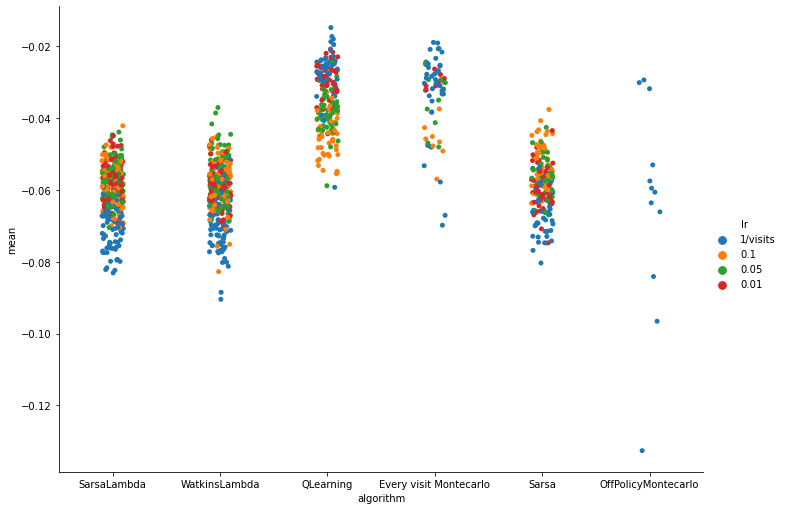

In [53]:
sns.catplot(data=clean_leaderboard, x='algorithm', y='mean', hue='lr', height=7,  aspect=7/5);

**Conclusions**: 
1. Decaying learning rates outperform fix learning rates for QLearning and Every-visit Montecarlo.
2. On the other hand, they generate lacklustre performances for SarsaLambda, Sarsa and Watkins Lambda.

#### Expected rewards distribution per algorithm and discount rate:

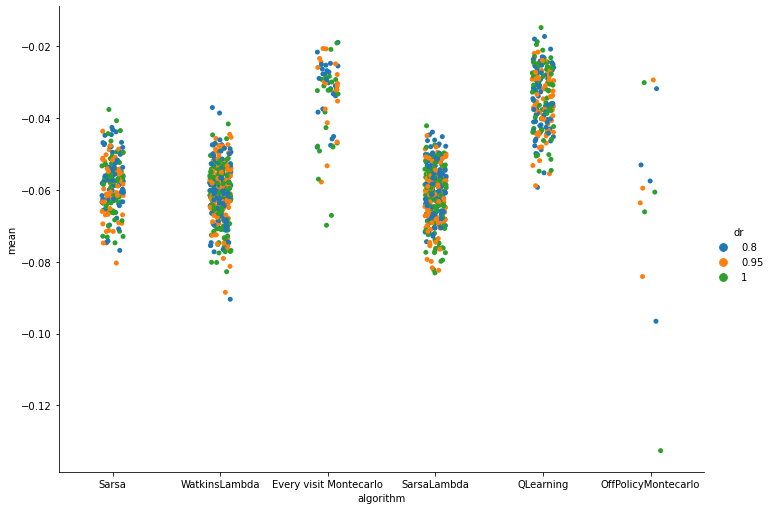

In [38]:
sns.catplot(data=clean_leaderboard, x='algorithm', y='mean', hue='dr', height=7,  aspect=7/5);

**Conclusions**: 
1. Discount rate does not look like a decisive performance driver. It might be due to the fact that episodes tend to be short.
2. At most, it could be stated that 0.8 discount rate help ensure a mininum performance for both SarsaLambda and Every-visit Montecarlo; there are not blue dots at the lower tail of their distributions.

#### Expected rewards distribution per algorithm and exploration strategy:

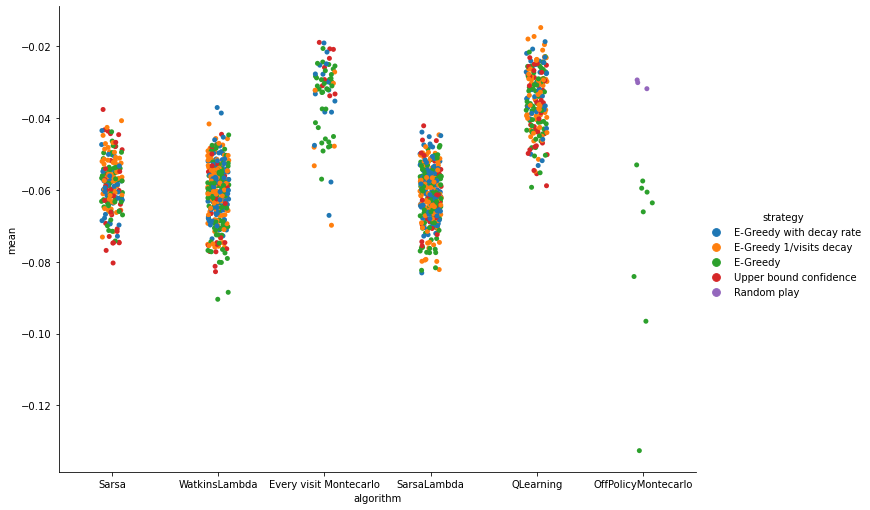

In [39]:
sns.catplot(data=clean_leaderboard, x='algorithm', y='mean', hue='strategy', height=7,  aspect=7/5);

**Conclusions**: 
1. Playing randomly outperforms playing greedily for OffPolicyMontecarlo.
2. Upper bound confidence ensure better results for Every visit Montecarlo.
3. E-greedy with any kind of decay gives the top performances for QLearning, which in turn are the overall top performances.

#### Expected rewards distribution per exploration strategy and learning rate:

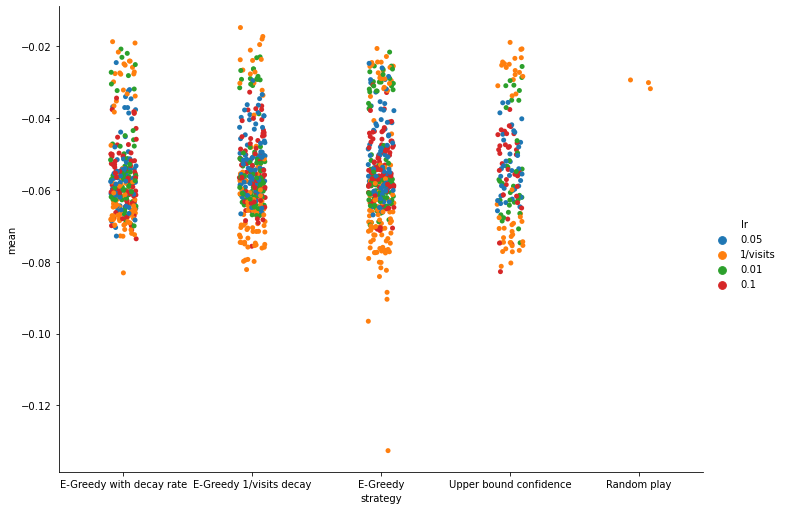

In [40]:
sns.catplot(data=clean_leaderboard, x='strategy', y='mean', hue='lr', height=7,  aspect=7/5);

**Conclusions**: 
1. No strategy outperforms the others.
2. Decaying learning rate has a very extreme behaviour: producing best and worst performances per strategy.
3. 0.1 learning rate seems too big and really produces lacklustre results. (That may also be one the reasons why Sarsa, WatkinsLambda and SarsaLambda are not performing well: best results for those algorithms are achieved with such learning rate (see above) and may be like a ceiling. Narrowing down the rate of exploration look like the only possibility to make up for it.)

#### Expected rewards distribution per exploration strategy and discount rate:

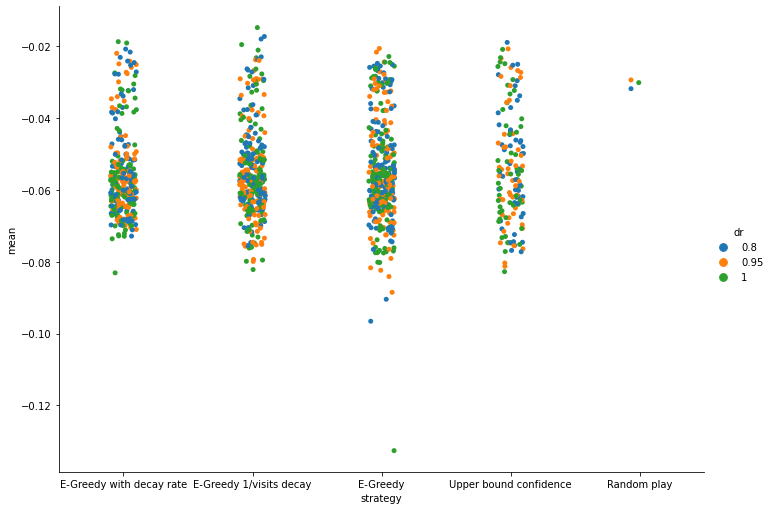

In [41]:
sns.catplot(data=clean_leaderboard, x='strategy', y='mean', hue='dr', height=7,  aspect=7/5);

**Conclusions**: 
1. Discount rate is not conclusive against the strategy backdrop
#### Expected rewards distribution per lambda and learning rate:

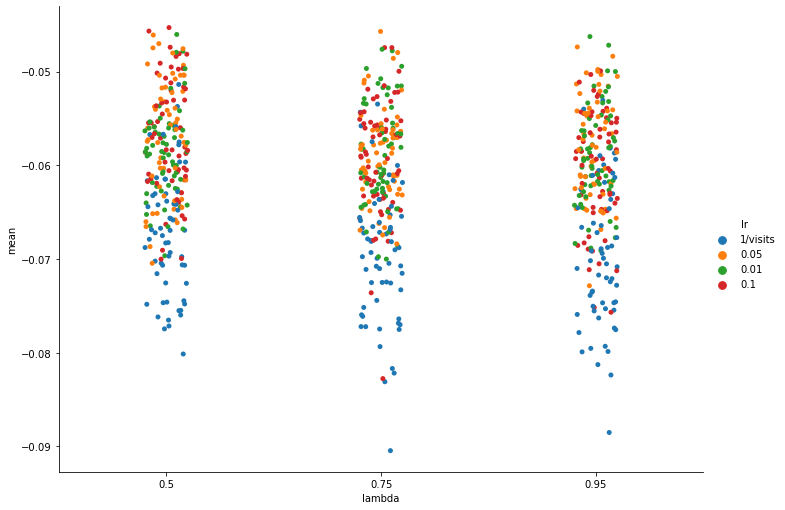

In [79]:
sns.catplot(data=clean_leaderboard[clean_leaderboard['lambda']!='N/A'], x='lambda', y='mean', hue='lr', height=7,  aspect=7/5);

**Conclusions**: 
1. Lambda rate does not look a performance driver.
2. Lambda 0.5 reduces the number of negative extreme cases.
3. Learning rate produces the same negative effect regardless of the lambda value.
#### Expected rewards distribution per upper bound confidene c parameter and learning rate:

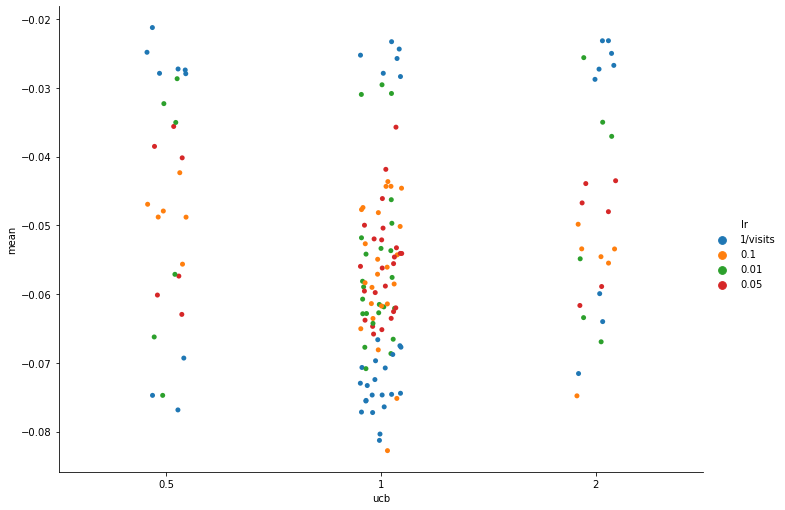

In [83]:
sns.catplot(data=clean_leaderboard[clean_leaderboard['ucb']!='N/A'], x='ucb', y='mean', hue='lr', height=7,  aspect=7/5);

**Conclusions**: 
1. c param does not look like a performance driver.
2. Decaying learning or small learning rate look necessary but not sufficient conditions to boost performance.

## Choosing candidates for a retake:

I will pick the top 5 best performers of the 4 worst algorithms to see if some of them surpass the house edge after 1M more episodes of training: 

In [43]:
retakers_algorithms = ['OffPolicyMontecarlo', 'Sarsa', 'SarsaLambda', 'WatkinsLambda' ]
def top(df, n=5):
    return df.sort_values('mean', ascending=False).head(5)

retakers = clean_leaderboard[clean_leaderboard['algorithm'].isin(retakers_algorithms)].groupby('algorithm').apply(top)
retakers

algorithm  \
algorithm                                                                                     
OffPolicyMontecarlo A_RandomOffPolicyMC_832a12bccf6142b6a5b53394760...  OffPolicyMontecarlo   
                    A_RandomOffPolicyMC_df727aa114854b10a746c89c3cc...  OffPolicyMontecarlo   
                    A_RandomOffPolicyMC_89f2c667bde94e12b3a9ef54b71...  OffPolicyMontecarlo   
                    A_GreedyOffPolicyMC_a6a5886faf054e4585f67fd3123...  OffPolicyMontecarlo   
                    A_GreedyOffPolicyMC_c43a8276ff09486594507cacbf9...  OffPolicyMontecarlo   
Sarsa               A_SarsaUCB_172450fda31d43ea9f67fdb101d001a8                       Sarsa   
                    A_SarsaVisitsDecay_95c0af8bfbaf4f68a0fc5ed7f564...                Sarsa   
                    A_SarsaVisitsDecay_dfa9f0ecad5d41b182c94732c44e...                Sarsa   
                    A_SarsaUCB_3d8f02d644ac4ef88df9ff908eaa5fda                       Sarsa   
                    A_SarsaDecayRate_41d042e8be5c49668459eda4ecb0bb97                 Sarsa   
SarsaLambda         A_SarsaLambdaUCB_e81436c59f96469aaa70d20ce6f1da34           SarsaLambda   
                    A_SarsaLambdaDecayRate_7d1d830597fc441aaca49c1b...          SarsaLambda   
                    A_SarsaLambdaVisitsDecay_2395be0d2855405bb14aa3...          SarsaLambda   
                    A_SarsaLambdaDecayRate_6affcf31e6354c5e9025a95b...          SarsaLambda   
                    A_SarsaLambdaDecayRate_f106347d9c5a4a05bc9a3023...          SarsaLambda   
WatkinsLambda       A_WatkinsDecayRate_f12f582698b449f6820e746dcbfd...        WatkinsLambda   
                    A_WatkinsDecayRate_d1d51e73325b4d468099dc4c5241...        WatkinsLambda   
                    A_WatkinsVisitsDecay_ca68f5ff6d1e43fbbcc061057b...        WatkinsLambda   
                    A_WatkinsUCB_05c676ea47e84540841e5787b329017e             WatkinsLambda   
                    A_WatkinsFixEpsilon_fe5de47d59ce4966a0f8e26351a...        WatkinsLambda   

                                                                                        strategy  \
algorithm                                                                                          
OffPolicyMontecarlo A_RandomOffPolicyMC_832a12bccf6142b6a5b53394760...               Random play   
                    A_RandomOffPolicyMC_df727aa114854b10a746c89c3cc...               Random play   
                    A_RandomOffPolicyMC_89f2c667bde94e12b3a9ef54b71...               Random play   
                    A_GreedyOffPolicyMC_a6a5886faf054e4585f67fd3123...                  E-Greedy   
                    A_GreedyOffPolicyMC_c43a8276ff09486594507cacbf9...                  E-Greedy   
Sarsa               A_SarsaUCB_172450fda31d43ea9f67fdb101d001a8           Upper bound confidence   
                    A_SarsaVisitsDecay_95c0af8bfbaf4f68a0fc5ed7f564...   E-Greedy 1/visits decay   
                    A_SarsaVisitsDecay_dfa9f0ecad5d41b182c94732c44e...   E-Greedy 1/visits decay   
                    A_SarsaUCB_3d8f02d644ac4ef88df9ff908eaa5fda           Upper bound confidence   
                    A_SarsaDecayRate_41d042e8be5c49668459eda4ecb0bb97   E-Greedy with decay rate   
SarsaLambda         A_SarsaLambdaUCB_e81436c59f96469aaa70d20ce6f1da34     Upper bound confidence   
                    A_SarsaLambdaDecayRate_7d1d830597fc441aaca49c1b...  E-Greedy with decay rate   
                    A_SarsaLambdaVisitsDecay_2395be0d2855405bb14aa3...   E-Greedy 1/visits decay   
                    A_SarsaLambdaDecayRate_6affcf31e6354c5e9025a95b...  E-Greedy with decay rate   
                    A_SarsaLambdaDecayRate_f106347d9c5a4a05bc9a3023...  E-Greedy with decay rate   
WatkinsLambda       A_WatkinsDecayRate_f12f582698b449f6820e746dcbfd...  E-Greedy with decay rate   
                    A_WatkinsDecayRate_d1d51e73325b4d468099dc4c5241...  E-Greedy with decay rate   
                    A_WatkinsVisitsDecay_ca68f5ff6d1e43fbbcc061057b...   E-Greedy 1/visits 

In [44]:
# list conversion:
retakers_list = [tup[1] for tup in retakers.index.to_list()]
retakers_list

['A_RandomOffPolicyMC_832a12bccf6142b6a5b5339476042481',
 'A_RandomOffPolicyMC_df727aa114854b10a746c89c3ccc8e40',
 'A_RandomOffPolicyMC_89f2c667bde94e12b3a9ef54b7161536',
 'A_GreedyOffPolicyMC_a6a5886faf054e4585f67fd3123d50e6',
 'A_GreedyOffPolicyMC_c43a8276ff09486594507cacbf9ff197',
 'A_SarsaUCB_172450fda31d43ea9f67fdb101d001a8',
 'A_SarsaVisitsDecay_95c0af8bfbaf4f68a0fc5ed7f564de45',
 'A_SarsaVisitsDecay_dfa9f0ecad5d41b182c94732c44e85a8',
 'A_SarsaUCB_3d8f02d644ac4ef88df9ff908eaa5fda',
 'A_SarsaDecayRate_41d042e8be5c49668459eda4ecb0bb97',
 'A_SarsaLambdaUCB_e81436c59f96469aaa70d20ce6f1da34',
 'A_SarsaLambdaDecayRate_7d1d830597fc441aaca49c1b86c996aa',
 'A_SarsaLambdaVisitsDecay_2395be0d2855405bb14aa337a87ff442',
 'A_SarsaLambdaDecayRate_6affcf31e6354c5e9025a95b84dc6aec',
 'A_SarsaLambdaDecayRate_f106347d9c5a4a05bc9a3023bad9ad3c',
 'A_WatkinsDecayRate_f12f582698b449f6820e746dcbfd86e2',
 'A_WatkinsDecayRate_d1d51e73325b4d468099dc4c524153ed',
 'A_WatkinsVisitsDecay_ca68f5ff6d1e43fbbcc061

In [45]:
#trying to retrieve agents' instances from their binary files
for retaker in retakers_list:
    agent = get_agent(retaker,criterion='most_trained')
    print(find_results(agent.__class__.__name__, agent.id))

[PosixPath('/home/xavi/Documents/Blackjack/results/results_RandomOffPolicyMC_832a12bccf6142b6a5b5339476042481_CON'), PosixPath('/home/xavi/Documents/Blackjack/results/results_RandomOffPolicyMC_832a12bccf6142b6a5b5339476042481_10M'), PosixPath('/home/xavi/Documents/Blackjack/results/results_RandomOffPolicyMC_832a12bccf6142b6a5b5339476042481_2M'), PosixPath('/home/xavi/Documents/Blackjack/results/results_RandomOffPolicyMC_832a12bccf6142b6a5b5339476042481_1M')]
[PosixPath('/home/xavi/Documents/Blackjack/results/results_RandomOffPolicyMC_df727aa114854b10a746c89c3ccc8e40_CON'), PosixPath('/home/xavi/Documents/Blackjack/results/results_RandomOffPolicyMC_df727aa114854b10a746c89c3ccc8e40_10M'), PosixPath('/home/xavi/Documents/Blackjack/results/results_RandomOffPolicyMC_df727aa114854b10a746c89c3ccc8e40_1M')]
[PosixPath('/home/xavi/Documents/Blackjack/results/results_RandomOffPolicyMC_89f2c667bde94e12b3a9ef54b7161536_10M'), PosixPath('/home/xavi/Documents/Blackjack/results/results_RandomOffPolic

In [46]:
#create an environment instance:
env = environments.make('hitstand')

`The following operations might take up to 1 hour of execution`

In [58]:
#let's train and persist new results:
for retaker in retakers_list:
    agent = get_agent(retaker,criterion='most_trained')
    
    if agent.num_executed_episodes < 1_000_000:        
        
        rewards = train_and_test(env, agent, 1_000_000, 1_000_000, bootstrap_samples=10, first_time=False)

        agent.save(agent.num_executed_episodes)
        file = FOLDER_PATH + 'results_{0}_{1}_2M'.format(agent.__class__.__name__,
                                                          str(agent.id)
                                                    )
        with open(file, 'wb') as f:
            pickle.dump(rewards, f)

## After the retake:

In [54]:
NUM_EPISODES = 2_000_000

In [55]:
#agents' retrieval for analysis
trained_agents = retrieve_agents_dict(NUM_EPISODES)

Let's lever on pandas:

In [56]:
leaderboard = pd.DataFrame(trained_agents).transpose()

In [57]:
clean_leaderboard = leaderboard[~leaderboard['mean'].isna()]

### Agents above the House Edge:

In [58]:
clean_leaderboard[clean_leaderboard['mean'] > -0.0235].sort_values('mean', ascending=False)

,algorithm,strategy,lr,dr,lambda,traces,ep_min,ep_decay,ucb,Last_episode,results,mean,lower_bound,upper_bound
A_QVisitsDecay_6cfb7d8b6df64593a88c8de054bebedd,QLearning,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.05,N/A,N/A,952838,"[-0.0055, -0.0350625, -0.010125, -0.0149375, -...",-0.014766,-0.032383,-0.001633
A_QVisitsDecay_a08b71ff7c0749618027631507a49bbf,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.005,N/A,N/A,952350,"[-0.033375, -0.01925, -0.023875, -0.0025, -0.0...",-0.01725,-0.031767,-0.003452
A_QVisitsDecay_a448d79b4b5b45258103e111d1c1f490,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.1,N/A,N/A,952516,"[-0.0285625, -0.0121875, -0.027625, -0.0255, -...",-0.017961,-0.028398,0.000586
A_VisitsDecay_bb55b4f8e9ce44419de60652ce304fac,Every visit Montecarlo,E-Greedy 1/visits decay,1/visits,0.95,N/A,N/A,0.01,N/A,N/A,1904754,"[-0.0205, -0.02975, -0.0053125, -0.0124375, -0...",-0.018438,-0.029159,-0.006231
A_QDecayRate_41eb1831b3fd43d5aab3e5b38422208a,QLearning,E-Greedy with decay rate,1/visits,1,N/A,N/A,0.005,0.99,N/A,952936,"[-0.02725, -0.0185625, -0.0061875, -0.012625, ...",-0.018695,-0.029931,-0.007314
A_UCB_dc93faabf62d4dd7b5f1596ff2e99bcb,Every visit Montecarlo,Upper bound confidence,1/visits,0.95,N/A,N/A,N/A,N/A,1,1905893,"[-0.0184375, -0.022125, -0.017375, -0.031125, ...",-0.018711,-0.03128,-0.003955
A_UCB_71ef7b7f83fa45618bbcb477383f57c8,Every visit Montecarlo,Upper bound confidence,1/visits,1,N/A,N/A,N/A,N/A,1,1905271,"[-0.0054375, -0.026625, -0.0364375, -0.007375,...",-0.018758,-0.036241,-0.005722
A_FixEpsilon_ce635cba29054b5687efbc8715035444,Every visit Montecarlo,E-Greedy,1/visits,0.8,N/A,N/A,0.05,N/A,N/A,1905999,"[-0.012125, -0.012875, -0.01875, -0.023125, -0...",-0.01882,-0.026778,-0.012256
A_FixEpsilon_1694735483da4ee5aa0b4e0c020a5225,Every visit Montecarlo,E-Greedy,1/visits,1,N/A,N/A,0.05,N/A,N/A,1905063,"[-0.0005, -0.012125, -0.046375, -0.0271875, -0...",-0.019133,-0.044089,-0.001353
A_UCB_e1f04e8b5044425fbbf582b3e4930c66,Every visit Montecarlo,Upper bound confidence,1/visits,1,N/A,N/A,N/A,N/A,2,1905445,"[-0.00825, -0.022875, -0.029375, -0.024125, -0...",-0.019336,-0.034067,-0.008403


In [59]:
#how many agents are there?
len(clean_leaderboard[clean_leaderboard['mean'] > -0.0235])

32

In [60]:
#Which algorithms are predominant in the top group?
clean_leaderboard[clean_leaderboard['mean'] > -0.0235].groupby('algorithm').size().sort_values(ascending=False)

algorithm
Every visit Montecarlo    17
QLearning                 14
OffPolicyMontecarlo        1
dtype: int64

**An OffPolicyMontecarlo agent** makes into the exclusive club of agents. No news from Sarsa, SarsaLambda and WatkinsLambda.

In [61]:
#Which exploration strategies are predominant in the top group?
clean_leaderboard[clean_leaderboard['mean'] > -0.0235].groupby('strategy').size().sort_values(ascending=False)

strategy
E-Greedy                    9
E-Greedy 1/visits decay     9
E-Greedy with decay rate    7
Upper bound confidence      6
Random play                 1
dtype: int64

##### Distribution per different quantiles:

In [62]:
def quantiles(df):
    dictionary = {}
    min_ = 0.9
    while min_ >= 0:
        min_ = max(min_,0)
        dictionary['Top_{0:.0%}'.format(1-min_)] = df[df['mean'] > df['mean'].quantile(min_)].groupby('algorithm').size()
        min_-= 0.1

          
    return pd.DataFrame(dictionary)

quantiles(clean_leaderboard[['algorithm', 'mean']]).fillna(0).applymap(lambda v: '{0:.0f}'.format(v))

,Top_10%,Top_20%,Top_30%,Top_40%,Top_50%,Top_60%,Top_70%,Top_80%,Top_90%,Top_100%
algorithm,,,,,,,,,,
Every visit Montecarlo,38,54,62,64,64,64,64,65,66,67
OffPolicyMontecarlo,3,3,3,5,7,8,9,9,9,11
QLearning,78,167,184,189,190,192,192,192,192,192
Sarsa,0,11,32,52,81,106,131,149,175,192
SarsaLambda,0,0,36,78,126,173,214,263,312,360
WatkinsLambda,0,2,38,84,123,167,218,268,310,360


As I had previously trained all Montecarlo up to 2M episodes, some have sneaked into the top_10%. No improvement by Sarsa, SarsaLambda and Watkins

`The following operations might take up to 1 hour of execution`

In [61]:
for retaker in retakers_list:
    agent = get_agent(retaker,criterion='most_trained')
    if agent.num_executed_episodes < 2_000_000:
              
        rewards = train_and_test(env, agent, 1_000_000, 1_000_000, bootstrap_samples=10, first_time=False)

        agent.save(agent.num_executed_episodes)
        file = FOLDER_PATH + 'results_{0}_{1}_3M'.format(agent.__class__.__name__,
                                                          str(agent.id)
                                                    )
        with open(file, 'wb') as f:
            pickle.dump(rewards, f)

Episode 1000000:
Jack:
	-Cards: ['3D', '5S']
	-Value : 8
Dealer:
	-Cards: ['3C']
	-Value : 3
Jack decides to: HIT
	-Cards: ['3D', '5S', '9C']
	-Value : 17
Jack decides to: STAND
	-Cards: ['3D', '5S', '9C']
	-Value : 17
Dealer:
	-Cards: ['3C', 'AC', '3S']
	-Value : 17
DRAW
Episode 1000000:
Jack:
	-Cards: ['9S', 'KD']
	-Value : 19
Dealer:
	-Cards: ['3C']
	-Value : 3
Jack decides to: STAND
	-Cards: ['9S', 'KD']
	-Value : 19
Dealer:
	-Cards: ['3C', '8S', '6C']
	-Value : 17
JACK BEATS THE HOUSE
Episode 1000000:
Jack:
	-Cards: ['JC', '4H']
	-Value : 14
Dealer:
	-Cards: ['7S']
	-Value : 7
Jack decides to: STAND
	-Cards: ['JC', '4H']
	-Value : 14
Dealer:
	-Cards: ['7S', '5D', 'QH']
	-Value : 22
JACK BEATS THE HOUSE
Episode 1000000:
Jack:
	-Cards: ['AD', '6D']
	-Value : 17
Dealer:
	-Cards: ['QS']
	-Value : 10
Jack decides to: HIT
	-Cards: ['AD', '6D', '10S']
	-Value : 17
Jack decides to: STAND
	-Cards: ['AD', '6D', '10S']
	-Value : 17
Dealer:
	-Cards: ['QS', '10D']
	-Value : 20
THE HOUSE BEATS 

## After the second retake:

**Same procedure with almost same results**

In [63]:
NUM_EPISODES = 3_000_000

In [64]:
#agents' retrieval for analysis
trained_agents = retrieve_agents_dict(NUM_EPISODES)

Let's lever on pandas:

In [65]:
leaderboard = pd.DataFrame(trained_agents).transpose()

In [66]:
clean_leaderboard = leaderboard[~leaderboard['mean'].isna()]

### Agents above the House Edge:

In [67]:
clean_leaderboard[clean_leaderboard['mean'] > -0.0235].sort_values('mean', ascending=False)

,algorithm,strategy,lr,dr,lambda,traces,ep_min,ep_decay,ucb,Last_episode,results,mean,lower_bound,upper_bound
A_QVisitsDecay_6cfb7d8b6df64593a88c8de054bebedd,QLearning,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.05,N/A,N/A,952838,"[-0.0055, -0.0350625, -0.010125, -0.0149375, -...",-0.014766,-0.032383,-0.001633
A_QVisitsDecay_a08b71ff7c0749618027631507a49bbf,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.005,N/A,N/A,952350,"[-0.033375, -0.01925, -0.023875, -0.0025, -0.0...",-0.01725,-0.031767,-0.003452
A_FixEpsilon_31bad91b04084908852b5c283cb2cf08,Every visit Montecarlo,E-Greedy,0.01,1,N/A,N/A,0.01,N/A,N/A,2858286,"[-0.024375, 0.0086875, -0.0294375, -0.0304375,...",-0.017672,-0.030262,0.005942
A_QVisitsDecay_a448d79b4b5b45258103e111d1c1f490,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.1,N/A,N/A,952516,"[-0.0285625, -0.0121875, -0.027625, -0.0255, -...",-0.017961,-0.028398,0.000586
A_QDecayRate_41eb1831b3fd43d5aab3e5b38422208a,QLearning,E-Greedy with decay rate,1/visits,1,N/A,N/A,0.005,0.99,N/A,952936,"[-0.02725, -0.0185625, -0.0061875, -0.012625, ...",-0.018695,-0.029931,-0.007314
A_DecayRate_a81ffac6ceef4e7abbedab434b11dca6,Every visit Montecarlo,E-Greedy with decay rate,1/visits,1,N/A,N/A,0.05,0.995,N/A,2857896,"[-0.012, -0.0079375, -0.0425625, -0.0140625, -...",-0.018859,-0.040473,-0.008648
A_QVisitsDecay_c688b215e42e40daa54c2249040a9a39,QLearning,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.005,N/A,N/A,952384,"[-0.0244375, -0.013625, -0.010375, -0.032625, ...",-0.019508,-0.035977,-0.000142
A_FixEpsilon_1b720ec52e6640e298a3b41eeb9043f4,Every visit Montecarlo,E-Greedy,0.01,0.8,N/A,N/A,0.1,N/A,N/A,2858875,"[-0.0105, -0.0226875, -0.0309375, -0.0308125, ...",-0.020047,-0.030916,-0.010795
A_FixEpsilon_1694735483da4ee5aa0b4e0c020a5225,Every visit Montecarlo,E-Greedy,1/visits,1,N/A,N/A,0.05,N/A,N/A,2857329,"[-0.0253125, -0.0288125, -0.016, -0.02675, 0.0...",-0.020242,-0.033092,0.002816
A_QDecayRate_b798d2c5acd64e658f52d0be9169d01e,QLearning,E-Greedy with decay rate,0.01,0.8,N/A,N/A,0.005,0.995,N/A,953002,"[-0.0295, -0.0213125, -0.017625, -0.01575, -0....",-0.020758,-0.029314,-0.011316


In [68]:
#how many agents are there?
len(clean_leaderboard[clean_leaderboard['mean'] > -0.0235])

27

In [69]:
#Which algorithms are predominant in the top group?
clean_leaderboard[clean_leaderboard['mean'] > -0.0235].groupby('algorithm').size().sort_values(ascending=False)

algorithm
QLearning                 14
Every visit Montecarlo    13
dtype: int64

The number of agents over the house edge diminishes. It indicates that some Montecarlo agents have entered into a fluctuating area; More bootstraping is definitely needed to assess results.

In [70]:
#Which exploration strategies are predominant in the top group?
clean_leaderboard[clean_leaderboard['mean'] > -0.0235].groupby('strategy').size().sort_values(ascending=False)

strategy
E-Greedy                    9
E-Greedy 1/visits decay     7
E-Greedy with decay rate    7
Upper bound confidence      4
dtype: int64

##### Distribution per different quantiles:

In [71]:
def quantiles(df):
    dictionary = {}
    min_ = 0.9
    while min_ >= 0:
        min_ = max(min_,0)
        dictionary['Top_{0:.0%}'.format(1-min_)] = df[df['mean'] > df['mean'].quantile(min_)].groupby('algorithm').size()
        min_-= 0.1

          
    return pd.DataFrame(dictionary)

quantiles(clean_leaderboard[['algorithm', 'mean']]).fillna(0).applymap(lambda v: '{0:.0f}'.format(v))

,Top_10%,Top_20%,Top_30%,Top_40%,Top_50%,Top_60%,Top_70%,Top_80%,Top_90%,Top_100%
algorithm,,,,,,,,,,
Every visit Montecarlo,40,56,60,61,62,64,64,65,66,67
OffPolicyMontecarlo,3,3,3,3,7,8,9,9,9,11
QLearning,76,169,184,189,190,192,192,192,192,192
Sarsa,0,6,32,61,85,111,130,151,175,192
SarsaLambda,0,0,36,77,125,171,214,262,312,360
WatkinsLambda,0,3,40,80,122,164,218,267,310,360


## Full bootstrapping for top 10 performers:

I will check if top 10 performers are really near the house edge.

In [72]:
top_10 = clean_leaderboard[clean_leaderboard['mean'] > -0.0235].sort_values('mean', ascending=False).head(10)

In [73]:
top_10

,algorithm,strategy,lr,dr,lambda,traces,ep_min,ep_decay,ucb,Last_episode,results,mean,lower_bound,upper_bound
A_QVisitsDecay_6cfb7d8b6df64593a88c8de054bebedd,QLearning,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.05,N/A,N/A,952838,"[-0.0055, -0.0350625, -0.010125, -0.0149375, -...",-0.014766,-0.032383,-0.001633
A_QVisitsDecay_a08b71ff7c0749618027631507a49bbf,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.005,N/A,N/A,952350,"[-0.033375, -0.01925, -0.023875, -0.0025, -0.0...",-0.01725,-0.031767,-0.003452
A_FixEpsilon_31bad91b04084908852b5c283cb2cf08,Every visit Montecarlo,E-Greedy,0.01,1,N/A,N/A,0.01,N/A,N/A,2858286,"[-0.024375, 0.0086875, -0.0294375, -0.0304375,...",-0.017672,-0.030262,0.005942
A_QVisitsDecay_a448d79b4b5b45258103e111d1c1f490,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.1,N/A,N/A,952516,"[-0.0285625, -0.0121875, -0.027625, -0.0255, -...",-0.017961,-0.028398,0.000586
A_QDecayRate_41eb1831b3fd43d5aab3e5b38422208a,QLearning,E-Greedy with decay rate,1/visits,1,N/A,N/A,0.005,0.99,N/A,952936,"[-0.02725, -0.0185625, -0.0061875, -0.012625, ...",-0.018695,-0.029931,-0.007314
A_DecayRate_a81ffac6ceef4e7abbedab434b11dca6,Every visit Montecarlo,E-Greedy with decay rate,1/visits,1,N/A,N/A,0.05,0.995,N/A,2857896,"[-0.012, -0.0079375, -0.0425625, -0.0140625, -...",-0.018859,-0.040473,-0.008648
A_QVisitsDecay_c688b215e42e40daa54c2249040a9a39,QLearning,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.005,N/A,N/A,952384,"[-0.0244375, -0.013625, -0.010375, -0.032625, ...",-0.019508,-0.035977,-0.000142
A_FixEpsilon_1b720ec52e6640e298a3b41eeb9043f4,Every visit Montecarlo,E-Greedy,0.01,0.8,N/A,N/A,0.1,N/A,N/A,2858875,"[-0.0105, -0.0226875, -0.0309375, -0.0308125, ...",-0.020047,-0.030916,-0.010795
A_FixEpsilon_1694735483da4ee5aa0b4e0c020a5225,Every visit Montecarlo,E-Greedy,1/visits,1,N/A,N/A,0.05,N/A,N/A,2857329,"[-0.0253125, -0.0288125, -0.016, -0.02675, 0.0...",-0.020242,-0.033092,0.002816
A_QDecayRate_b798d2c5acd64e658f52d0be9169d01e,QLearning,E-Greedy with decay rate,0.01,0.8,N/A,N/A,0.005,0.995,N/A,953002,"[-0.0295, -0.0213125, -0.017625, -0.01575, -0....",-0.020758,-0.029314,-0.011316


In [81]:
top_10_list = top_10.index.to_list()

`The following operations might take up to 75 minutes of execution`

In [86]:
top_10_rewards = []
for top_agent in top_10_list:
    agent = get_agent(top_agent,criterion='most_trained')

              
    rewards = train_and_test(env, agent, 10, 10, bootstrap_samples=1_000, first_time=False)
    top_10_rewards.append(rewards)
    agent.save(agent.num_executed_episodes)
    file = FOLDER_PATH + 'results_{0}_{1}_Final'.format(agent.__class__.__name__,
                                                          str(agent.id)
                                                    )
    with open(file, 'wb') as f:
        pickle.dump(rewards, f)              

Episode 1000000:
Jack:
	-Cards: ['8C', '4D']
	-Value : 12
Dealer:
	-Cards: ['7D']
	-Value : 7
Jack decides to: HIT
	-Cards: ['8C', '4D', 'AC']
	-Value : 13
Jack decides to: HIT
	-Cards: ['8C', '4D', 'AC', '9D']
	-Value : 22
Dealer:
	-Cards: ['7D']
	-Value : 7
THE HOUSE BEATS JACK
Episode 1000000:
Jack:
	-Cards: ['2D', '10H']
	-Value : 12
Dealer:
	-Cards: ['4C']
	-Value : 4
Jack decides to: STAND
	-Cards: ['2D', '10H']
	-Value : 12
Dealer:
	-Cards: ['4C', '5D', '10D']
	-Value : 19
THE HOUSE BEATS JACK
Episode 1000000:
Jack:
	-Cards: ['KS', '9D']
	-Value : 19
Dealer:
	-Cards: ['2H']
	-Value : 2
Jack decides to: STAND
	-Cards: ['KS', '9D']
	-Value : 19
Dealer:
	-Cards: ['2H', '10H', '5C']
	-Value : 17
JACK BEATS THE HOUSE
Episode 1000000:
Jack:
	-Cards: ['JH', '9D']
	-Value : 19
Dealer:
	-Cards: ['9H']
	-Value : 9
Jack decides to: STAND
DRAW	-Cards: ['JH', '9D']
	-Value : 19
Dealer:
	-Cards: ['9H', 'KH']
	-Value : 19

Episode 1000000:
Jack:
	-Cards: ['10S', '8H']
	-Value : 18
Dealer:
	-Ca

`The following operations might take up to 12 hours of execution`

QLearning agents' have been left behind with regards to the number of traning episodes. I enforce a final training session for them with full bootstrapping evaluation at the end of it:

In [113]:
new_rewards = []
for top_agent in top_10_list:
    agent = get_agent(top_agent,criterion='most_trained')
    if agent.num_executed_episodes < 1_000_000:
             
        rewards = train_and_test(env, agent, 24_000_000, 24_000_000, bootstrap_samples=1_000, first_time=False)
        new_rewards.append(rewards )
        agent.save(agent.num_executed_episodes)
        file = FOLDER_PATH + 'results_{0}_{1}_10M'.format(agent.__class__.__name__,
                                                          str(agent.id)
                                                    )
        with open(file, 'wb') as f:
            pickle.dump(rewards, f)

Episode 1000000:
Jack:
	-Cards: ['JH', '2D']
	-Value : 12
Dealer:
	-Cards: ['3H']
	-Value : 3
Jack decides to: HIT
	-Cards: ['JH', '2D', '4D']
	-Value : 16
Jack decides to: STAND
	-Cards: ['JH', '2D', '4D']
	-Value : 16
Dealer:
	-Cards: ['3H', '9D', '7D']
	-Value : 19
THE HOUSE BEATS JACK
Episode 2000000:
Jack:
	-Cards: ['JC', '6D']
	-Value : 16
Dealer:
	-Cards: ['9H']
	-Value : 9
Jack decides to: HIT
	-Cards: ['JC', '6D', 'KS']
	-Value : 26
Dealer:
	-Cards: ['9H']
	-Value : 9
THE HOUSE BEATS JACK
Episode 3000000:
Jack:
	-Cards: ['9H', '9C']
	-Value : 18
Dealer:
	-Cards: ['9C']
	-Value : 9
Jack decides to: STAND
	-Cards: ['9H', '9C']
	-Value : 18
Dealer:
	-Cards: ['9C', '3S', 'KC']
	-Value : 22
JACK BEATS THE HOUSE
Episode 4000000:
Jack:
	-Cards: ['2S', '9C']
	-Value : 11
Dealer:
	-Cards: ['3H']
	-Value : 3
Jack decides to: HIT
	-Cards: ['2S', '9C', 'AS']
	-Value : 12
Jack decides to: HIT
	-Cards: ['2S', '9C', 'AS', '6S']
	-Value : 18
Jack decides to: STAND
	-Cards: ['2S', '9C', 'AS', 

## After the final bootstrapping:

### Generating a final summary for top 10 performers:

In [75]:
NUM_EPISODES = 100_000_000

In [76]:
#agents' retrieval for analysis
last_trained_agents = retrieve_agents_dict(NUM_EPISODES)

Let's lever on pandas:

In [77]:
last_leaderboard = pd.DataFrame(last_trained_agents).transpose()

In [78]:
last_clean_leaderboard = last_leaderboard[~last_leaderboard['mean'].isna()]

In [79]:
last_clean_leaderboard['Last_episode'] = last_clean_leaderboard['Last_episode'].apply(lambda v: '{:,.0f}'.format(v))

<ipython-input-79-9caec993d81b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_clean_leaderboard['Last_episode'] = last_clean_leaderboard['Last_episode'].apply(lambda v: '{:,.0f}'.format(v))


In [82]:
last_clean_leaderboard.loc[top_10_list].sort_values('mean', ascending=False)

,algorithm,strategy,lr,dr,lambda,traces,ep_min,ep_decay,ucb,Last_episode,results,mean,lower_bound,upper_bound
A_FixEpsilon_1694735483da4ee5aa0b4e0c020a5225,Every visit Montecarlo,E-Greedy,1/visits,1,N/A,N/A,0.05,N/A,N/A,"95,265,681","[-0.0089375, -0.0270625, -0.043, -0.004125, -0...",-0.023746,-0.046128,-0.003187
A_QDecayRate_41eb1831b3fd43d5aab3e5b38422208a,QLearning,E-Greedy with decay rate,1/visits,1,N/A,N/A,0.005,0.99,N/A,"23,816,286","[-0.0109375, -0.006125, -0.0331875, -0.0243125...",-0.023957,-0.046939,-0.002247
A_QVisitsDecay_a448d79b4b5b45258103e111d1c1f490,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.1,N/A,N/A,"23,815,582","[-0.043875, -0.005875, -0.025875, -0.0280625, ...",-0.024177,-0.044942,-0.002625
A_DecayRate_a81ffac6ceef4e7abbedab434b11dca6,Every visit Montecarlo,E-Greedy with decay rate,1/visits,1,N/A,N/A,0.05,0.995,N/A,"9,526,672","[-0.0211875, -0.019, -0.0213125, -0.0259375, -...",-0.024241,-0.045378,-0.002998
A_QVisitsDecay_6cfb7d8b6df64593a88c8de054bebedd,QLearning,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.05,N/A,N/A,"23,818,797","[-0.01925, -0.0125, -0.0200625, -0.0111875, -0...",-0.024536,-0.045137,-0.003059
A_QVisitsDecay_c688b215e42e40daa54c2249040a9a39,QLearning,E-Greedy 1/visits decay,1/visits,1,N/A,N/A,0.005,N/A,N/A,"23,816,316","[-0.0440625, -0.0084375, -0.027, -0.0195625, -...",-0.024632,-0.045439,-0.0015
A_QVisitsDecay_a08b71ff7c0749618027631507a49bbf,QLearning,E-Greedy 1/visits decay,1/visits,0.8,N/A,N/A,0.005,N/A,N/A,"23,818,173","[-0.0300625, -0.0304375, -0.0221875, -0.029, -...",-0.025197,-0.046133,-0.003427
A_QDecayRate_b798d2c5acd64e658f52d0be9169d01e,QLearning,E-Greedy with decay rate,0.01,0.8,N/A,N/A,0.005,0.995,N/A,"23,816,340","[-0.013125, -0.030875, -0.0230625, -0.038, -0....",-0.026211,-0.046634,-0.005812
A_FixEpsilon_31bad91b04084908852b5c283cb2cf08,Every visit Montecarlo,E-Greedy,0.01,1,N/A,N/A,0.01,N/A,N/A,"9,527,478","[-0.02075, -0.0165, -0.0464375, -0.03475, -0.0...",-0.027991,-0.048817,-0.00587
A_FixEpsilon_1b720ec52e6640e298a3b41eeb9043f4,Every visit Montecarlo,E-Greedy,0.01,0.8,N/A,N/A,0.1,N/A,N/A,"9,527,776","[-0.0334375, -0.0206875, -0.0071875, -0.032375...",-0.029118,-0.051081,-0.006687


**No agent reaches the house edge of 0.0235. However, house edge falls within all 95% CI**. Top 5 agents are really close to make it!

In [83]:
sorted_top_10_list = last_clean_leaderboard.loc[top_10_list].sort_values('mean', ascending=False).index.to_list()

### Visualising inferred policies:

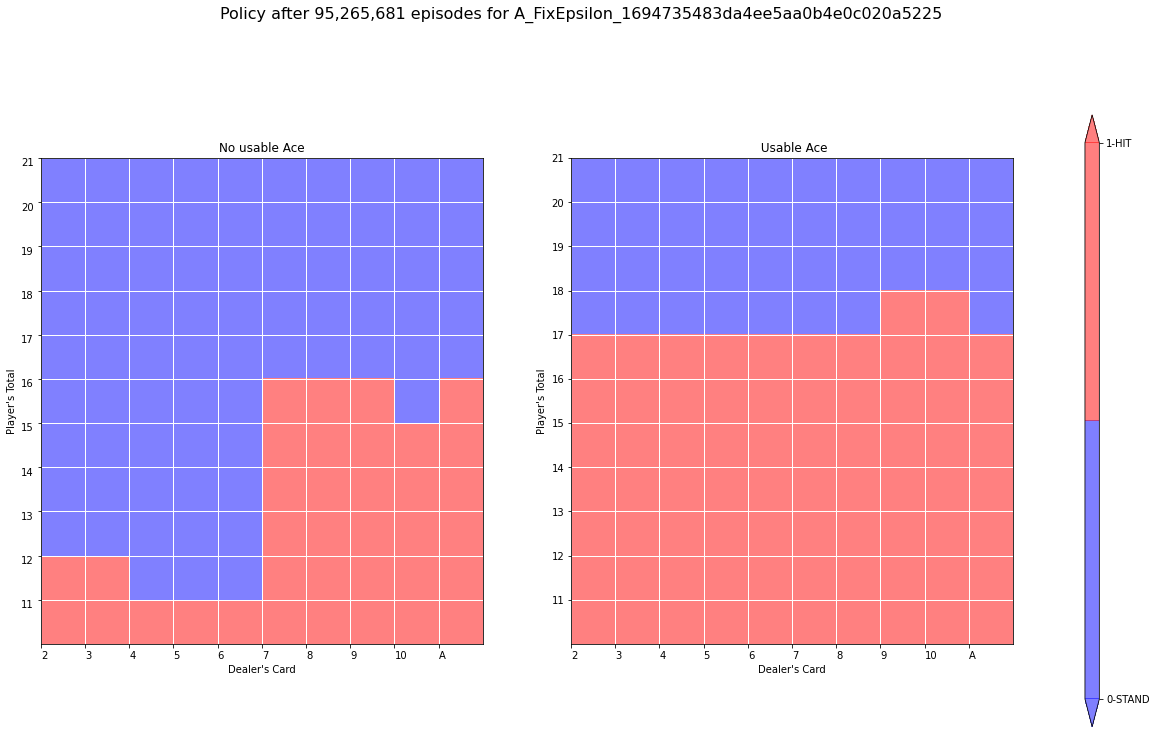

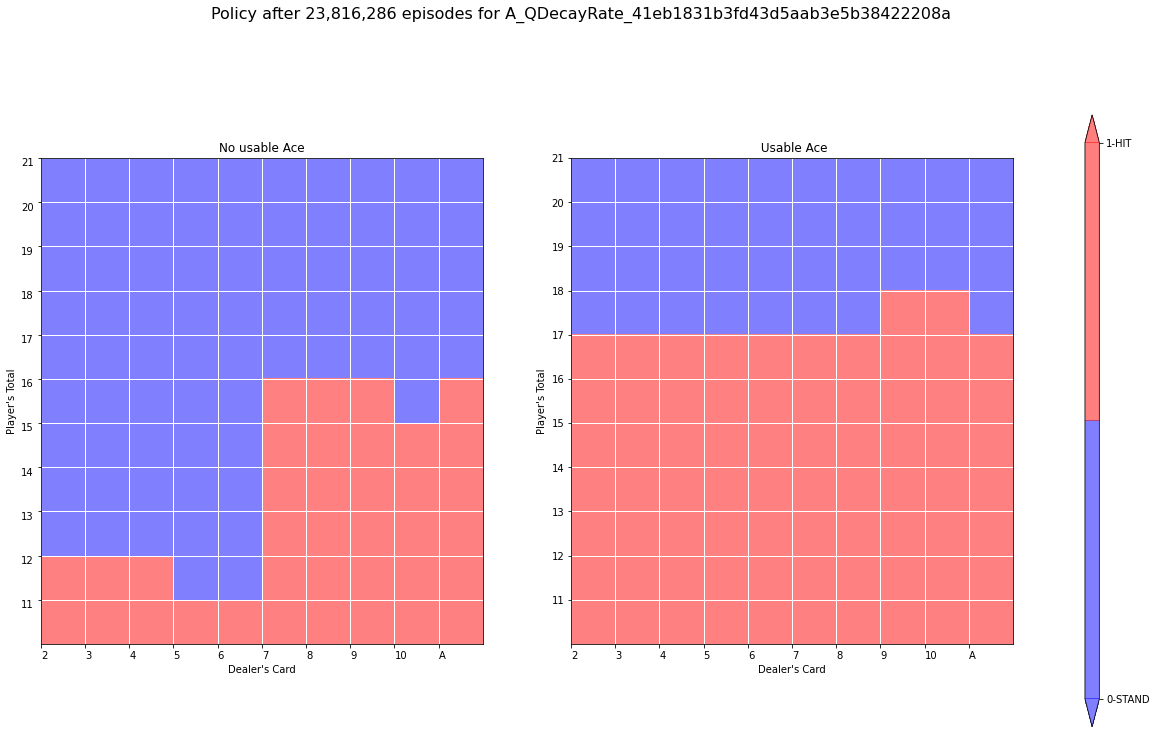

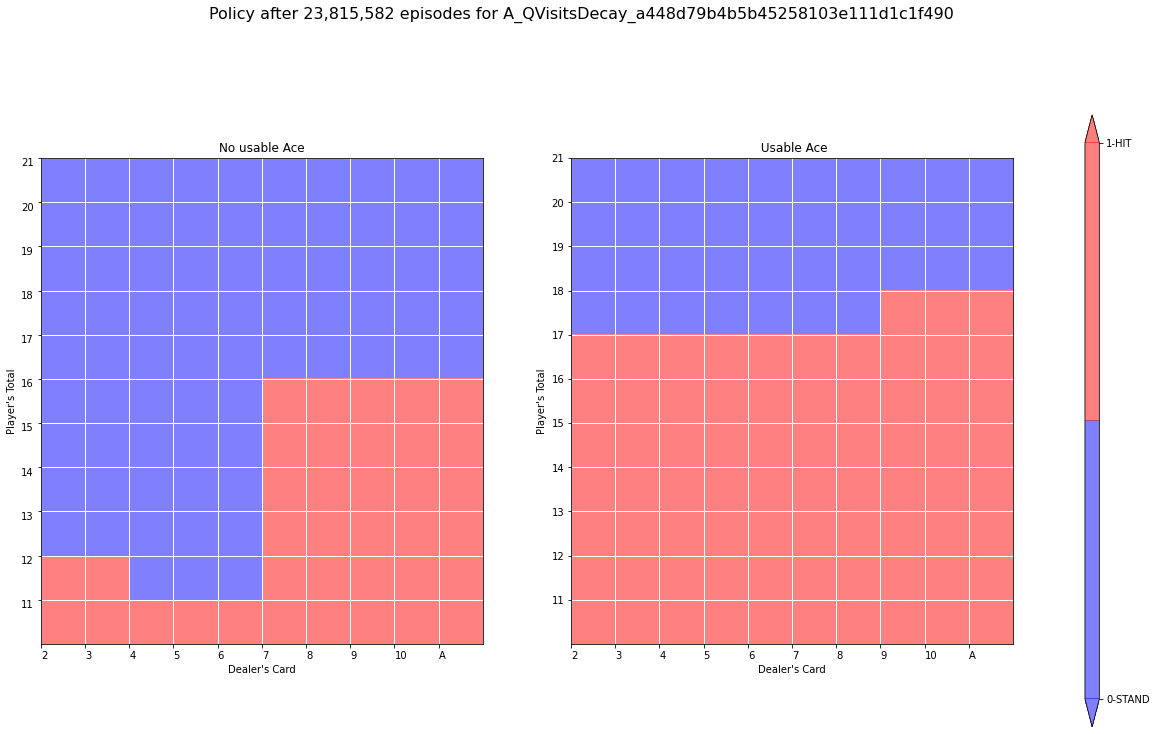

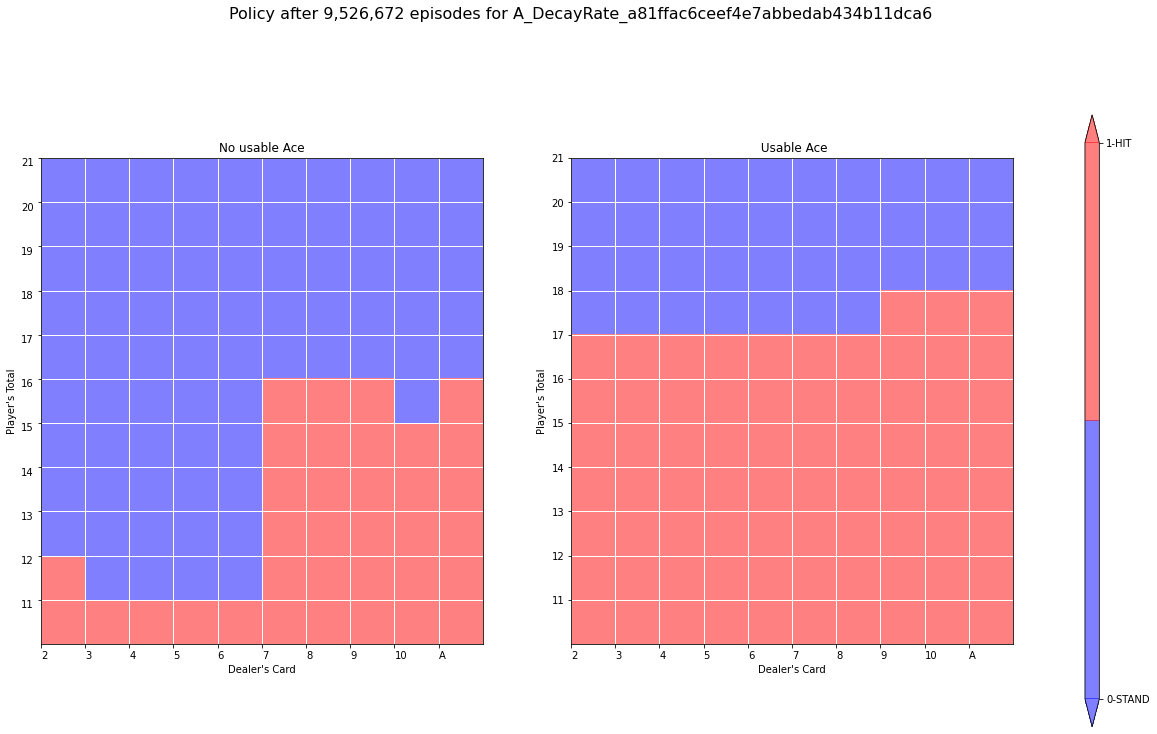

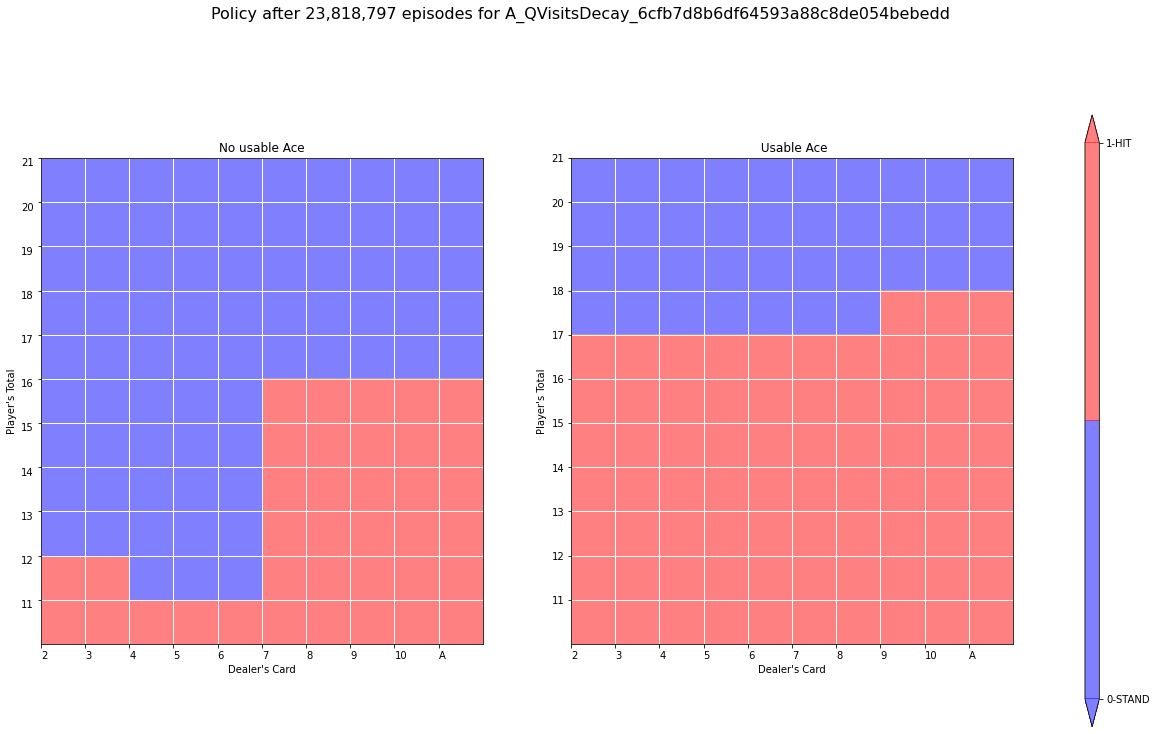

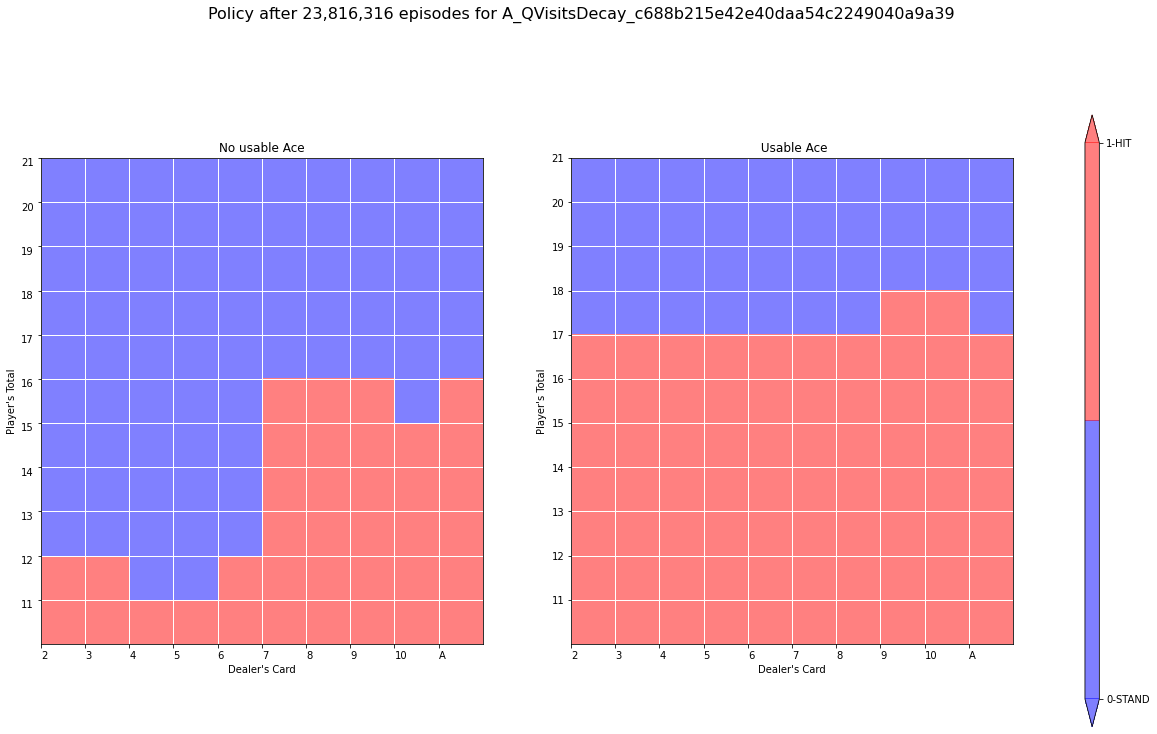

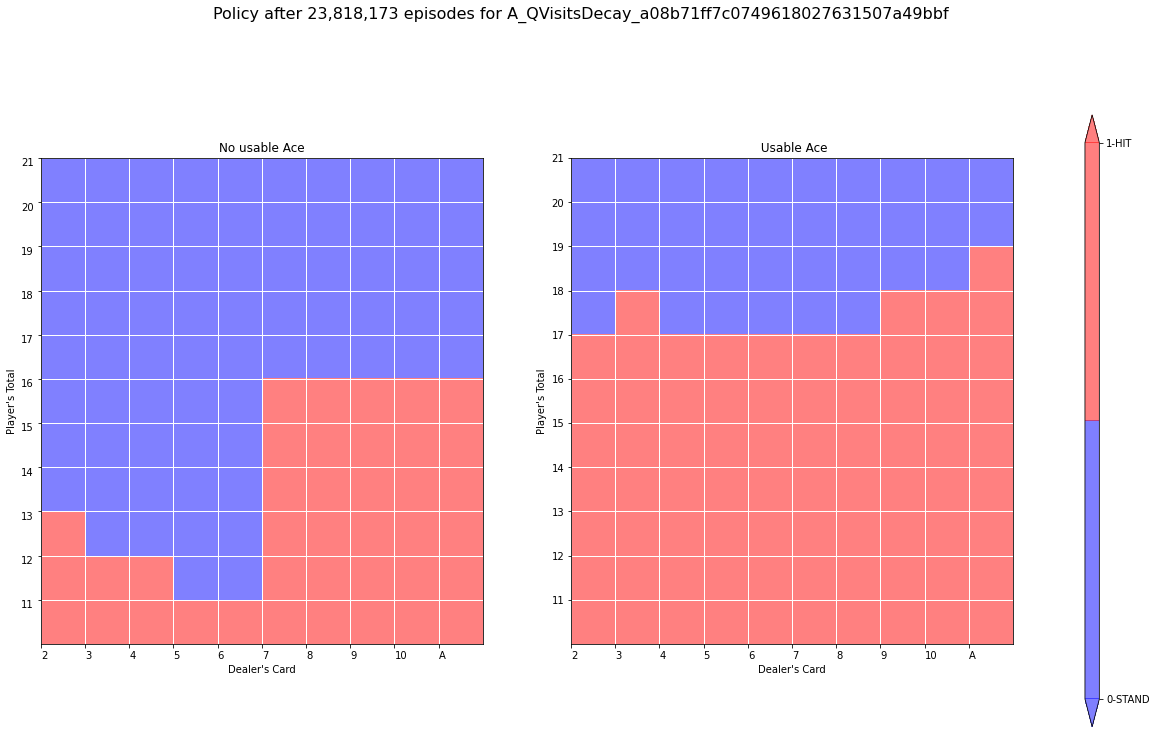

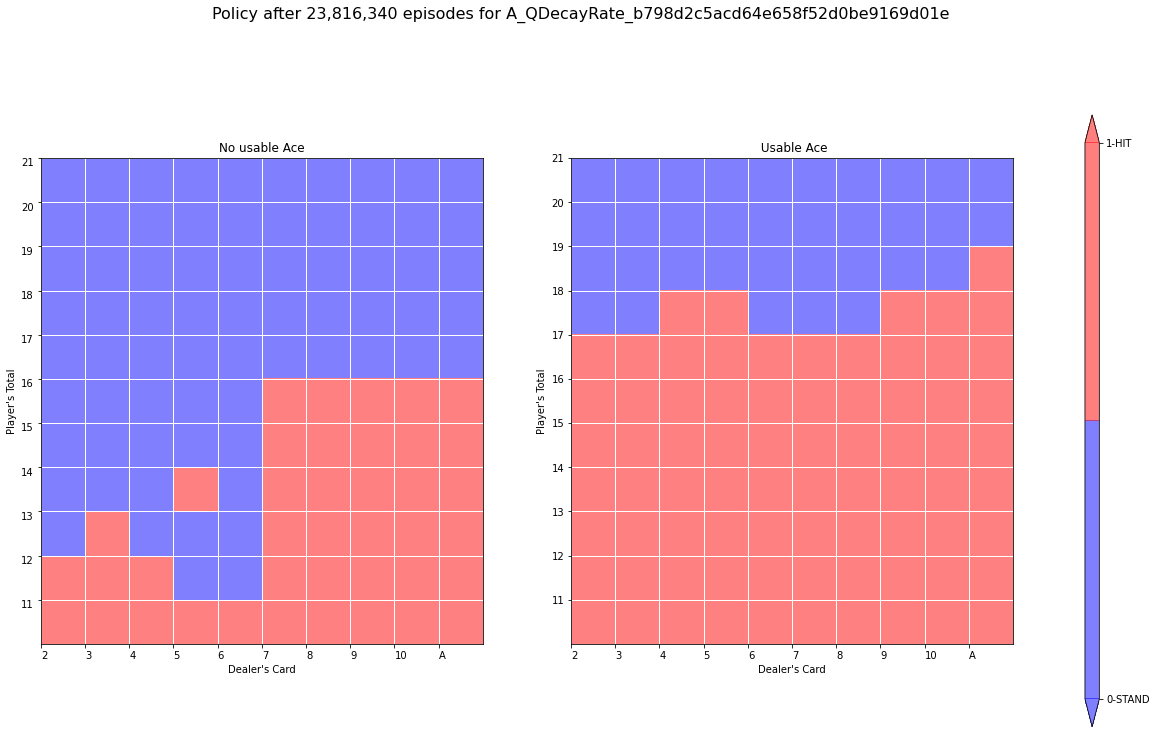

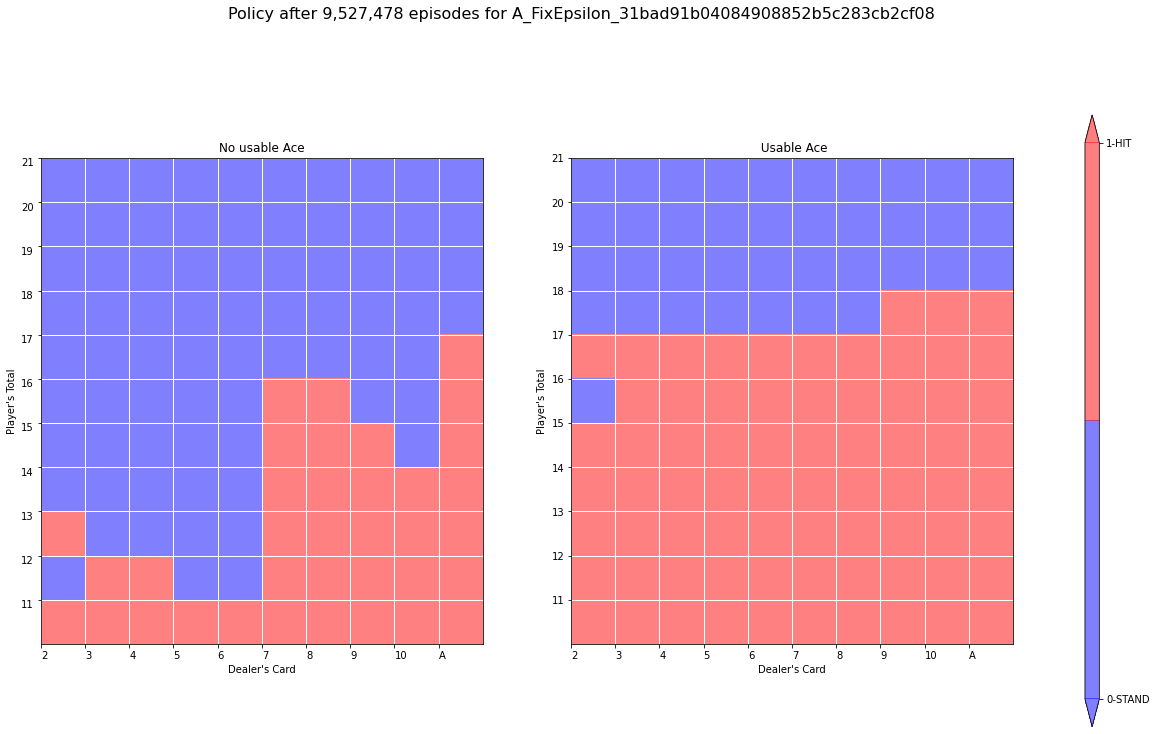

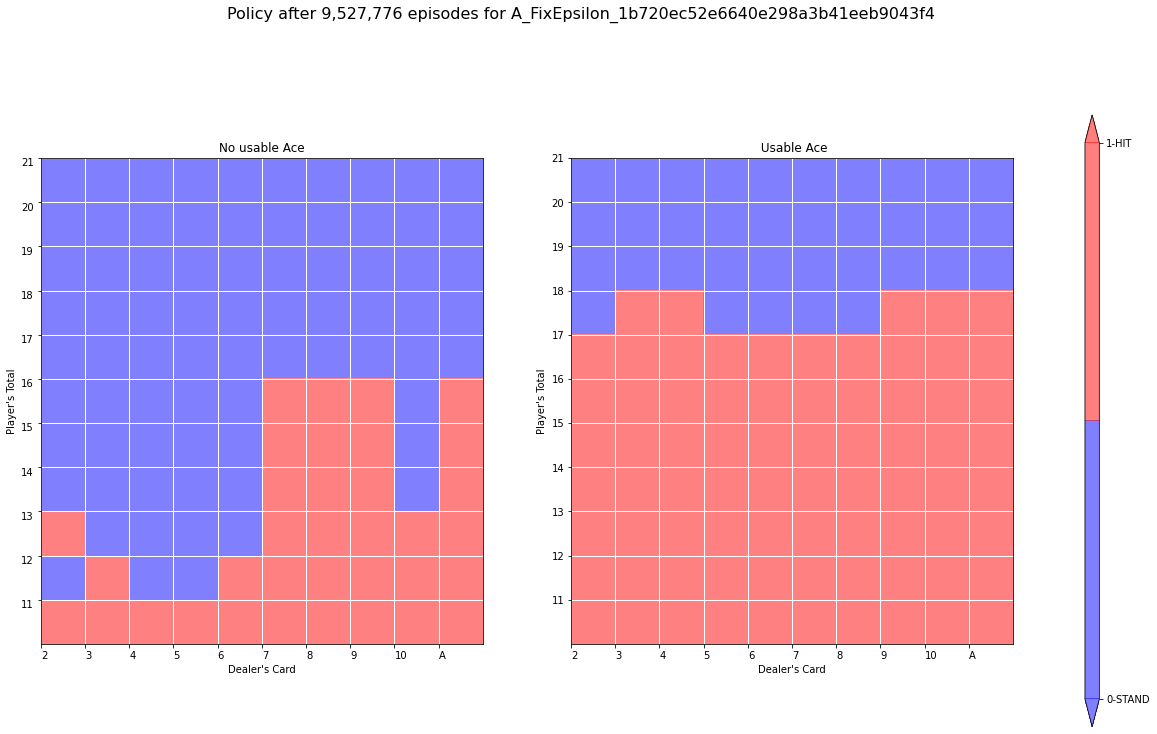

In [154]:
for top_agent in sorted_top_10_list:
    agent = get_agent(top_agent,criterion='most_trained')
    policy_table = np.argmax(agent.table, axis=3)
    plot_policy(policy_table, 'Policy after {0:,.0f} episodes for {1}'.format(agent.num_executed_episodes, top_agent))

**Finding**: top 8 policies look very similar but are not exactly the same. Hetereogenity of policies for very similar outcomes.

## Result consolidation:

After executing some discountinued trainning session, I must consolidate the binary files thereof into one single file:

In [86]:
for agent in top_10_list:
    agent = get_agent(agent,criterion='most_trained')
    consolidate_results(agent, override=True)

In [89]:
for agent in top_10_list:
    print(agent)

sorted_top_10_list

A_QVisitsDecay_6cfb7d8b6df64593a88c8de054bebedd
A_QVisitsDecay_a08b71ff7c0749618027631507a49bbf
A_FixEpsilon_31bad91b04084908852b5c283cb2cf08
A_QVisitsDecay_a448d79b4b5b45258103e111d1c1f490
A_QDecayRate_41eb1831b3fd43d5aab3e5b38422208a
A_DecayRate_a81ffac6ceef4e7abbedab434b11dca6
A_QVisitsDecay_c688b215e42e40daa54c2249040a9a39
A_FixEpsilon_1b720ec52e6640e298a3b41eeb9043f4
A_FixEpsilon_1694735483da4ee5aa0b4e0c020a5225
A_QDecayRate_b798d2c5acd64e658f52d0be9169d01e


['A_FixEpsilon_1694735483da4ee5aa0b4e0c020a5225',
 'A_QDecayRate_41eb1831b3fd43d5aab3e5b38422208a',
 'A_QVisitsDecay_a448d79b4b5b45258103e111d1c1f490',
 'A_DecayRate_a81ffac6ceef4e7abbedab434b11dca6',
 'A_QVisitsDecay_6cfb7d8b6df64593a88c8de054bebedd',
 'A_QVisitsDecay_c688b215e42e40daa54c2249040a9a39',
 'A_QVisitsDecay_a08b71ff7c0749618027631507a49bbf',
 'A_QDecayRate_b798d2c5acd64e658f52d0be9169d01e',
 'A_FixEpsilon_31bad91b04084908852b5c283cb2cf08',
 'A_FixEpsilon_1b720ec52e6640e298a3b41eeb9043f4']

In [96]:
complementary_group = clean_leaderboard[~clean_leaderboard.index.isin(top_10_list)].index.to_list()

In [98]:
for agent in complementary_group:
    agent = get_agent(agent,criterion='most_trained')
    consolidate_results(agent, override=True)

In [101]:
leaderboard[leaderboard['mean'].isna()].index.to_list()

['A_FixEpsilon_fd1f72645ff54bda8d657bc204415c66',
 'A_UCB_c53ebd1c23634775a8d0e3a79ccaeac5',
 'A_UCB_253fabab6dc54090adb37a71a16e2b5a',
 'A_FixEpsilon_1e2748d2c9dc4b25940dca10393f47f2',
 'A_VisitsDecay_3c6267913c894118a9e60bc796652cc7',
 'A_UCB_d9546ca2809d43e4b8b5be4a5d5c33ac',
 'A_UCB_341235ec2ac7476981f9be3281506c7a',
 'A_DecayRate_2923aed748004df4819f142b64433e8e',
 'A_AlwaysGreedy_3cab8bb2ecd94981bd57c46af642e9f8']